In [1]:
import os
import sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
tf.logging.set_verbosity(tf.logging.ERROR)

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Using TensorFlow backend.


In [0]:
class DCGAN(object):

    def __init__(self, img_rows=28, img_cols=28, channel=1):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel

        # The discriminator and generator
        self.D = None
        self.G = None

        # Adversarial model and discriminator model
        self.AM = None
        self.DM = None

    def discriminator(self):

        # Input:  28x28x1 image of a number, depth = 1

        if self.D:
            return self.D

        depth = 64
        dropout = 0.4

        self.D = Sequential()

        input_shape = (self.img_rows, self.img_cols, self.channel)

        self.D.add(
            Conv2D(
                depth*1,
                5,
                strides=2,
                input_shape=input_shape,
                padding='same',
                activation=LeakyReLU(alpha=0.2)
            )
        )
        self.D.add(
            Dropout(dropout)
        )

        self.D.add(
            Conv2D(
                depth*2,
                5,
                strides=2,
                input_shape=input_shape,
                padding='same',
                activation=LeakyReLU(alpha=0.2)
            )
        )
        self.D.add(
            Dropout(dropout)
        )

        self.D.add(
            Conv2D(
                depth*4,
                5,
                strides=2,
                input_shape=input_shape,
                padding='same',
                activation=LeakyReLU(alpha=0.2)
            )
        )
        self.D.add(
            Dropout(dropout)
        )

        self.D.add(
            Conv2D(
                depth*8,
                5,
                strides=2,
                input_shape=input_shape,
                padding='same',
                activation=LeakyReLU(alpha=0.2)
            )
        )
        self.D.add(
            Dropout(dropout)
        )
        # Current State: 14x14x1 convolution feature map, depth=64

        self.D.add(
            Flatten()
        )
        self.D.add(
            Dense(1)
        )
        self.D.add(
            Activation('sigmoid')
        )
        # Current State: Scalar prediction (whether or not generated)

        self.D.summary()
        return self.D

    def generator(self):

        # Input Dimensions: 100

        if self.G:
            return self.G

        depth = 64 + 64 + 64 + 64
        dropout = 0.4
        dim = 7

        self.G = Sequential()

        self.G.add(
            Dense(
                dim * dim * depth,
                input_dim = 100
            )
        )
        self.G.add(
            BatchNormalization(momentum=0.9)
        )
        self.G.add(
            Activation('relu')
        )
        self.G.add(
            Reshape((dim, dim, depth))
        )
        self.G.add(
            Dropout(dropout)
        )
        # Current Dimensions: dim x dim x depth

        self.G.add(
            UpSampling2D()
        )
        self.G.add(
            Conv2DTranspose(
                int(depth/2),
                5,
                padding='same'
            )
        )
        self.G.add(
            BatchNormalization(momentum=0.9)
        )
        self.G.add(
            Activation('relu')
        )

        self.G.add(
            UpSampling2D()
        )
        self.G.add(
            Conv2DTranspose(
                int(depth/4),
                5,
                padding='same'
            )
        )
        self.G.add(
            BatchNormalization(momentum=0.9)
        )
        self.G.add(
            Activation('relu')
        )

        self.G.add(
            Conv2DTranspose(
                int(depth/4),
                5,
                padding='same'
            )
        )
        self.G.add(
            BatchNormalization(momentum=0.9)
        )
        self.G.add(
            Activation('relu')
        )
        # Current Dimensions: 2*dim x 2*dim x depth/2

        self.G.add(
            Conv2DTranspose(
                1,
                5,
                padding='same'
            )
        )
        self.G.add(
            Activation('sigmoid')
        )
        # Current Dimensions: 28 x 28 x 1 grayscale image [0.0,1.0] per pix

        self.G.summary()
        return self.G

    def discriminator_model(self):

        if self.DM:
            return self.DM

        loss = 'binary_crossentropy'
        optimizer = RMSprop(lr=0.0002, decay=6e-8)

        self.DM = Sequential()

        self.DM.add(
            self.discriminator()
        )

        self.DM.compile(
            loss=loss,
            optimizer=optimizer,
            metrics=['accuracy']
        )

        return self.DM

    def adversarial_model(self):

        if self.AM:
            return self.AM

        loss = 'binary_crossentropy'
        optimizer = RMSprop(lr=0.0001, decay=3e-8)

        self.AM = Sequential()

        self.AM.add(
            self.generator(),
        )
        self.AM.add(
            self.discriminator()
        )

        self.AM.compile(
            loss=loss,
            optimizer=optimizer,
            metrics=['accuracy']
        )

        return self.AM

In [0]:
def train(
    x_train,
    generator,
    discriminator,
    adversarial,
    img_rows, img_cols,
    train_steps=2000,
    batch_size=256,
    save_interval=0):

    noise_input = None

    if save_interval > 0:
        noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])

    print("==Training==")
    for i in range(train_steps):

        # The actual data samples
        images_train = x_train[np.random.randint(
            0,
            x_train.shape[0],
            size=batch_size), :, :, :]

        # Our input to the generator NN
        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])

        # Forward pass of the generator NN to produce fake images
        images_fake = generator.predict(noise)

        # Make an input for the discriminator 0 = fake, 1 = real
        x = np.concatenate((images_train, images_fake))
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0

        d_loss = discriminator.train_on_batch(x, y)

        y = np.ones([batch_size, 1])

        noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])

        a_loss = adversarial.train_on_batch(noise, y)

        print("Epoch %d:\n\tD Network Loss: %.3f Accuracy: %.3f" % (i, d_loss[0], d_loss[1]))
        print("\tOverall A Loss: %.3f Accuracy: %.3f" % (a_loss[0], a_loss[1]))

        if (i % 10 == 0):
            plot_images(
                x_train,
                img_rows, img_cols,
                generator,
                save=False,
                fake=True,
                samples=16,
                noise=None,
                step=i+1
            )

    generator.save('trained_generator.model')
    discriminator.save('trained_discriminator.model')
    adversarial.save('trained_adversarial.model')

In [0]:
def plot_images(
    x_train,
    img_rows,
    img_cols,
    generator,
    save=True,
    fake=True,
    samples=16,
    noise=None,
    step=0):

    filename = 'mnist_{}_train_steps.png'.format(step)

    if fake:
        if noise is None:
            noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
        else:
            filename = 'mnist_{}.png'.format(step)
        images = generator.predict(noise)
    else:
        i = np.random.randint(0, x_train.shape[0], samples)
        images = x_train[i, :, :, :]

    plt.figure()

    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [img_rows, img_cols])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    if save:
        plt.savefig(filename)
        plt.close('all')
    else:
        plt.show()

Beginning number generation
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/t10k-labels-idx1-ubyte.gz
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
batch_normalization_1 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_1 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Re

/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_4 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 512)         3277312   
__________

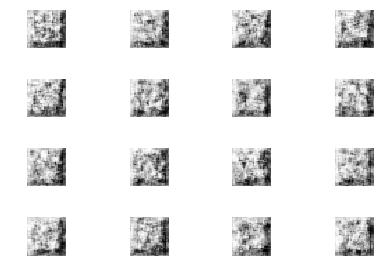

Epoch 1:
	D Network Loss: 0.688 Accuracy: 0.500
	Overall A Loss: 0.869 Accuracy: 0.000
Epoch 2:
	D Network Loss: 0.642 Accuracy: 0.943
	Overall A Loss: 0.901 Accuracy: 0.000
Epoch 3:
	D Network Loss: 0.551 Accuracy: 0.818
	Overall A Loss: 1.145 Accuracy: 0.000
Epoch 4:
	D Network Loss: 0.539 Accuracy: 0.998
	Overall A Loss: 0.588 Accuracy: 0.918
Epoch 5:
	D Network Loss: 1.309 Accuracy: 0.500
	Overall A Loss: 1.038 Accuracy: 0.000
Epoch 6:
	D Network Loss: 0.456 Accuracy: 0.994
	Overall A Loss: 0.867 Accuracy: 0.004
Epoch 7:
	D Network Loss: 0.506 Accuracy: 0.586
	Overall A Loss: 0.879 Accuracy: 0.023
Epoch 8:
	D Network Loss: 0.626 Accuracy: 0.500
	Overall A Loss: 1.075 Accuracy: 0.000
Epoch 9:
	D Network Loss: 0.582 Accuracy: 0.504
	Overall A Loss: 1.036 Accuracy: 0.000
Epoch 10:
	D Network Loss: 0.569 Accuracy: 0.506
	Overall A Loss: 1.037 Accuracy: 0.000


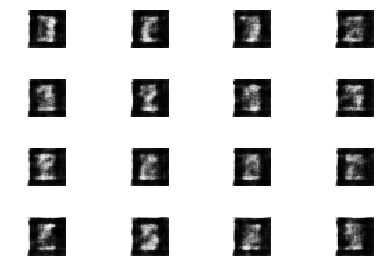

Epoch 11:
	D Network Loss: 0.561 Accuracy: 0.508
	Overall A Loss: 1.103 Accuracy: 0.000
Epoch 12:
	D Network Loss: 0.536 Accuracy: 0.518
	Overall A Loss: 1.078 Accuracy: 0.000
Epoch 13:
	D Network Loss: 0.523 Accuracy: 0.537
	Overall A Loss: 1.115 Accuracy: 0.000
Epoch 14:
	D Network Loss: 0.518 Accuracy: 0.562
	Overall A Loss: 1.187 Accuracy: 0.000
Epoch 15:
	D Network Loss: 0.471 Accuracy: 0.738
	Overall A Loss: 0.972 Accuracy: 0.027
Epoch 16:
	D Network Loss: 0.623 Accuracy: 0.500
	Overall A Loss: 1.721 Accuracy: 0.000
Epoch 17:
	D Network Loss: 0.583 Accuracy: 0.740
	Overall A Loss: 0.767 Accuracy: 0.270
Epoch 18:
	D Network Loss: 0.630 Accuracy: 0.506
	Overall A Loss: 1.089 Accuracy: 0.000
Epoch 19:
	D Network Loss: 0.463 Accuracy: 0.863
	Overall A Loss: 0.935 Accuracy: 0.023
Epoch 20:
	D Network Loss: 0.559 Accuracy: 0.527
	Overall A Loss: 1.239 Accuracy: 0.000


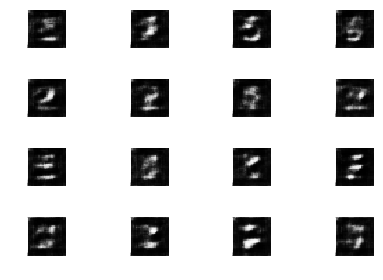

Epoch 21:
	D Network Loss: 0.462 Accuracy: 0.904
	Overall A Loss: 0.909 Accuracy: 0.082
Epoch 22:
	D Network Loss: 0.603 Accuracy: 0.510
	Overall A Loss: 1.390 Accuracy: 0.000
Epoch 23:
	D Network Loss: 0.505 Accuracy: 0.902
	Overall A Loss: 0.738 Accuracy: 0.371
Epoch 24:
	D Network Loss: 0.755 Accuracy: 0.502
	Overall A Loss: 1.383 Accuracy: 0.000
Epoch 25:
	D Network Loss: 0.517 Accuracy: 0.869
	Overall A Loss: 0.818 Accuracy: 0.152
Epoch 26:
	D Network Loss: 0.615 Accuracy: 0.508
	Overall A Loss: 1.152 Accuracy: 0.000
Epoch 27:
	D Network Loss: 0.462 Accuracy: 0.902
	Overall A Loss: 0.925 Accuracy: 0.062
Epoch 28:
	D Network Loss: 0.555 Accuracy: 0.549
	Overall A Loss: 1.236 Accuracy: 0.000
Epoch 29:
	D Network Loss: 0.459 Accuracy: 0.875
	Overall A Loss: 0.923 Accuracy: 0.055
Epoch 30:
	D Network Loss: 0.601 Accuracy: 0.523
	Overall A Loss: 1.289 Accuracy: 0.000


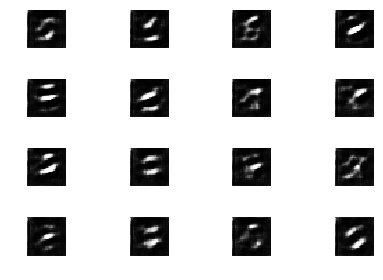

Epoch 31:
	D Network Loss: 0.501 Accuracy: 0.920
	Overall A Loss: 0.678 Accuracy: 0.570
Epoch 32:
	D Network Loss: 0.701 Accuracy: 0.508
	Overall A Loss: 1.237 Accuracy: 0.000
Epoch 33:
	D Network Loss: 0.539 Accuracy: 0.887
	Overall A Loss: 0.596 Accuracy: 0.762
Epoch 34:
	D Network Loss: 0.731 Accuracy: 0.500
	Overall A Loss: 1.082 Accuracy: 0.000
Epoch 35:
	D Network Loss: 0.544 Accuracy: 0.812
	Overall A Loss: 0.666 Accuracy: 0.582
Epoch 36:
	D Network Loss: 0.660 Accuracy: 0.500
	Overall A Loss: 1.062 Accuracy: 0.000
Epoch 37:
	D Network Loss: 0.538 Accuracy: 0.760
	Overall A Loss: 0.673 Accuracy: 0.613
Epoch 38:
	D Network Loss: 0.678 Accuracy: 0.504
	Overall A Loss: 1.076 Accuracy: 0.008
Epoch 39:
	D Network Loss: 0.550 Accuracy: 0.762
	Overall A Loss: 0.673 Accuracy: 0.578
Epoch 40:
	D Network Loss: 0.689 Accuracy: 0.498
	Overall A Loss: 1.146 Accuracy: 0.000


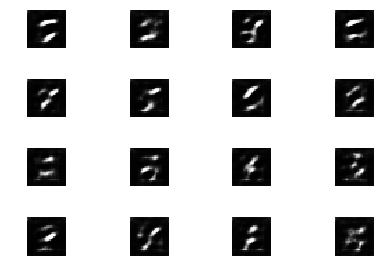

Epoch 41:
	D Network Loss: 0.557 Accuracy: 0.805
	Overall A Loss: 0.592 Accuracy: 0.797
Epoch 42:
	D Network Loss: 0.735 Accuracy: 0.500
	Overall A Loss: 1.141 Accuracy: 0.000
Epoch 43:
	D Network Loss: 0.578 Accuracy: 0.828
	Overall A Loss: 0.553 Accuracy: 0.879
Epoch 44:
	D Network Loss: 0.746 Accuracy: 0.500
	Overall A Loss: 1.065 Accuracy: 0.004
Epoch 45:
	D Network Loss: 0.568 Accuracy: 0.768
	Overall A Loss: 0.640 Accuracy: 0.703
Epoch 46:
	D Network Loss: 0.704 Accuracy: 0.500
	Overall A Loss: 1.048 Accuracy: 0.000
Epoch 47:
	D Network Loss: 0.578 Accuracy: 0.707
	Overall A Loss: 0.675 Accuracy: 0.566
Epoch 48:
	D Network Loss: 0.682 Accuracy: 0.500
	Overall A Loss: 1.064 Accuracy: 0.004
Epoch 49:
	D Network Loss: 0.576 Accuracy: 0.740
	Overall A Loss: 0.650 Accuracy: 0.656
Epoch 50:
	D Network Loss: 0.727 Accuracy: 0.500
	Overall A Loss: 1.146 Accuracy: 0.000


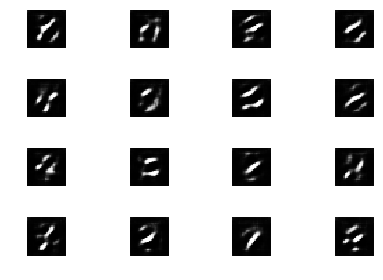

Epoch 51:
	D Network Loss: 0.598 Accuracy: 0.775
	Overall A Loss: 0.586 Accuracy: 0.840
Epoch 52:
	D Network Loss: 0.761 Accuracy: 0.500
	Overall A Loss: 1.095 Accuracy: 0.000
Epoch 53:
	D Network Loss: 0.599 Accuracy: 0.748
	Overall A Loss: 0.634 Accuracy: 0.711
Epoch 54:
	D Network Loss: 0.708 Accuracy: 0.502
	Overall A Loss: 1.002 Accuracy: 0.004
Epoch 55:
	D Network Loss: 0.593 Accuracy: 0.697
	Overall A Loss: 0.698 Accuracy: 0.500
Epoch 56:
	D Network Loss: 0.692 Accuracy: 0.502
	Overall A Loss: 1.034 Accuracy: 0.008
Epoch 57:
	D Network Loss: 0.586 Accuracy: 0.707
	Overall A Loss: 0.720 Accuracy: 0.402
Epoch 58:
	D Network Loss: 0.708 Accuracy: 0.500
	Overall A Loss: 1.116 Accuracy: 0.000
Epoch 59:
	D Network Loss: 0.598 Accuracy: 0.752
	Overall A Loss: 0.622 Accuracy: 0.719
Epoch 60:
	D Network Loss: 0.746 Accuracy: 0.500
	Overall A Loss: 1.135 Accuracy: 0.000


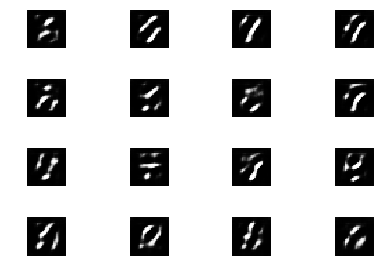

Epoch 61:
	D Network Loss: 0.605 Accuracy: 0.750
	Overall A Loss: 0.634 Accuracy: 0.691
Epoch 62:
	D Network Loss: 0.717 Accuracy: 0.500
	Overall A Loss: 1.111 Accuracy: 0.000
Epoch 63:
	D Network Loss: 0.610 Accuracy: 0.729
	Overall A Loss: 0.677 Accuracy: 0.555
Epoch 64:
	D Network Loss: 0.698 Accuracy: 0.500
	Overall A Loss: 1.093 Accuracy: 0.000
Epoch 65:
	D Network Loss: 0.609 Accuracy: 0.713
	Overall A Loss: 0.725 Accuracy: 0.379
Epoch 66:
	D Network Loss: 0.695 Accuracy: 0.500
	Overall A Loss: 1.123 Accuracy: 0.000
Epoch 67:
	D Network Loss: 0.602 Accuracy: 0.748
	Overall A Loss: 0.718 Accuracy: 0.402
Epoch 68:
	D Network Loss: 0.692 Accuracy: 0.504
	Overall A Loss: 1.171 Accuracy: 0.000
Epoch 69:
	D Network Loss: 0.593 Accuracy: 0.807
	Overall A Loss: 0.665 Accuracy: 0.629
Epoch 70:
	D Network Loss: 0.727 Accuracy: 0.500
	Overall A Loss: 1.237 Accuracy: 0.000


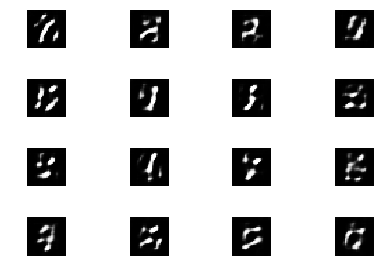

Epoch 71:
	D Network Loss: 0.618 Accuracy: 0.756
	Overall A Loss: 0.642 Accuracy: 0.664
Epoch 72:
	D Network Loss: 0.731 Accuracy: 0.500
	Overall A Loss: 1.128 Accuracy: 0.000
Epoch 73:
	D Network Loss: 0.599 Accuracy: 0.785
	Overall A Loss: 0.734 Accuracy: 0.379
Epoch 74:
	D Network Loss: 0.688 Accuracy: 0.502
	Overall A Loss: 1.107 Accuracy: 0.000
Epoch 75:
	D Network Loss: 0.604 Accuracy: 0.721
	Overall A Loss: 0.774 Accuracy: 0.270
Epoch 76:
	D Network Loss: 0.683 Accuracy: 0.508
	Overall A Loss: 1.165 Accuracy: 0.000
Epoch 77:
	D Network Loss: 0.598 Accuracy: 0.795
	Overall A Loss: 0.724 Accuracy: 0.406
Epoch 78:
	D Network Loss: 0.706 Accuracy: 0.500
	Overall A Loss: 1.301 Accuracy: 0.000
Epoch 79:
	D Network Loss: 0.618 Accuracy: 0.723
	Overall A Loss: 0.637 Accuracy: 0.707
Epoch 80:
	D Network Loss: 0.733 Accuracy: 0.500
	Overall A Loss: 1.195 Accuracy: 0.000


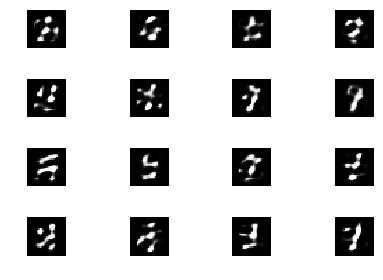

Epoch 81:
	D Network Loss: 0.617 Accuracy: 0.766
	Overall A Loss: 0.675 Accuracy: 0.555
Epoch 82:
	D Network Loss: 0.713 Accuracy: 0.504
	Overall A Loss: 1.134 Accuracy: 0.000
Epoch 83:
	D Network Loss: 0.617 Accuracy: 0.762
	Overall A Loss: 0.727 Accuracy: 0.379
Epoch 84:
	D Network Loss: 0.715 Accuracy: 0.500
	Overall A Loss: 1.154 Accuracy: 0.000
Epoch 85:
	D Network Loss: 0.625 Accuracy: 0.723
	Overall A Loss: 0.731 Accuracy: 0.359
Epoch 86:
	D Network Loss: 0.706 Accuracy: 0.504
	Overall A Loss: 1.118 Accuracy: 0.000
Epoch 87:
	D Network Loss: 0.624 Accuracy: 0.717
	Overall A Loss: 0.736 Accuracy: 0.375
Epoch 88:
	D Network Loss: 0.723 Accuracy: 0.500
	Overall A Loss: 1.173 Accuracy: 0.000
Epoch 89:
	D Network Loss: 0.634 Accuracy: 0.693
	Overall A Loss: 0.667 Accuracy: 0.594
Epoch 90:
	D Network Loss: 0.738 Accuracy: 0.500
	Overall A Loss: 1.191 Accuracy: 0.000


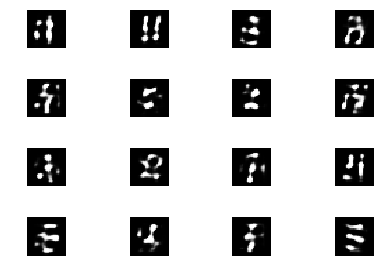

Epoch 91:
	D Network Loss: 0.637 Accuracy: 0.703
	Overall A Loss: 0.688 Accuracy: 0.531
Epoch 92:
	D Network Loss: 0.733 Accuracy: 0.498
	Overall A Loss: 1.172 Accuracy: 0.000
Epoch 93:
	D Network Loss: 0.645 Accuracy: 0.666
	Overall A Loss: 0.694 Accuracy: 0.531
Epoch 94:
	D Network Loss: 0.743 Accuracy: 0.500
	Overall A Loss: 1.181 Accuracy: 0.000
Epoch 95:
	D Network Loss: 0.656 Accuracy: 0.631
	Overall A Loss: 0.678 Accuracy: 0.586
Epoch 96:
	D Network Loss: 0.737 Accuracy: 0.504
	Overall A Loss: 1.126 Accuracy: 0.000
Epoch 97:
	D Network Loss: 0.649 Accuracy: 0.684
	Overall A Loss: 0.709 Accuracy: 0.457
Epoch 98:
	D Network Loss: 0.713 Accuracy: 0.506
	Overall A Loss: 1.095 Accuracy: 0.004
Epoch 99:
	D Network Loss: 0.653 Accuracy: 0.646
	Overall A Loss: 0.716 Accuracy: 0.453
Epoch 100:
	D Network Loss: 0.729 Accuracy: 0.498
	Overall A Loss: 1.132 Accuracy: 0.000


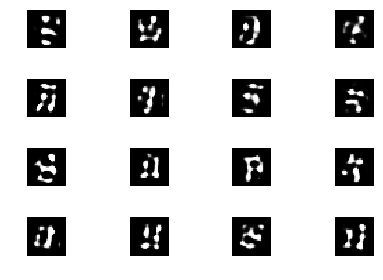

Epoch 101:
	D Network Loss: 0.655 Accuracy: 0.656
	Overall A Loss: 0.718 Accuracy: 0.430
Epoch 102:
	D Network Loss: 0.734 Accuracy: 0.500
	Overall A Loss: 1.157 Accuracy: 0.000
Epoch 103:
	D Network Loss: 0.663 Accuracy: 0.641
	Overall A Loss: 0.681 Accuracy: 0.547
Epoch 104:
	D Network Loss: 0.749 Accuracy: 0.500
	Overall A Loss: 1.099 Accuracy: 0.004
Epoch 105:
	D Network Loss: 0.663 Accuracy: 0.633
	Overall A Loss: 0.708 Accuracy: 0.477
Epoch 106:
	D Network Loss: 0.717 Accuracy: 0.506
	Overall A Loss: 1.048 Accuracy: 0.000
Epoch 107:
	D Network Loss: 0.664 Accuracy: 0.619
	Overall A Loss: 0.745 Accuracy: 0.367
Epoch 108:
	D Network Loss: 0.708 Accuracy: 0.510
	Overall A Loss: 1.023 Accuracy: 0.004
Epoch 109:
	D Network Loss: 0.662 Accuracy: 0.652
	Overall A Loss: 0.738 Accuracy: 0.328
Epoch 110:
	D Network Loss: 0.706 Accuracy: 0.506
	Overall A Loss: 1.083 Accuracy: 0.000


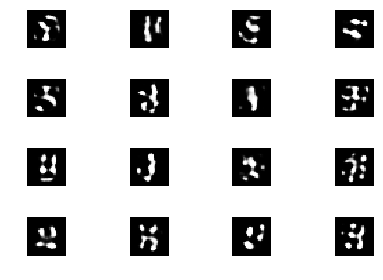

Epoch 111:
	D Network Loss: 0.656 Accuracy: 0.656
	Overall A Loss: 0.716 Accuracy: 0.398
Epoch 112:
	D Network Loss: 0.700 Accuracy: 0.506
	Overall A Loss: 1.086 Accuracy: 0.000
Epoch 113:
	D Network Loss: 0.646 Accuracy: 0.682
	Overall A Loss: 0.678 Accuracy: 0.559
Epoch 114:
	D Network Loss: 0.717 Accuracy: 0.502
	Overall A Loss: 1.134 Accuracy: 0.000
Epoch 115:
	D Network Loss: 0.657 Accuracy: 0.635
	Overall A Loss: 0.681 Accuracy: 0.523
Epoch 116:
	D Network Loss: 0.704 Accuracy: 0.496
	Overall A Loss: 1.065 Accuracy: 0.000
Epoch 117:
	D Network Loss: 0.641 Accuracy: 0.674
	Overall A Loss: 0.722 Accuracy: 0.434
Epoch 118:
	D Network Loss: 0.692 Accuracy: 0.502
	Overall A Loss: 1.076 Accuracy: 0.000
Epoch 119:
	D Network Loss: 0.645 Accuracy: 0.707
	Overall A Loss: 0.703 Accuracy: 0.438
Epoch 120:
	D Network Loss: 0.700 Accuracy: 0.502
	Overall A Loss: 1.081 Accuracy: 0.000


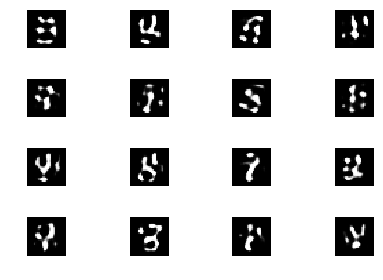

Epoch 121:
	D Network Loss: 0.629 Accuracy: 0.738
	Overall A Loss: 0.722 Accuracy: 0.383
Epoch 122:
	D Network Loss: 0.711 Accuracy: 0.500
	Overall A Loss: 1.112 Accuracy: 0.000
Epoch 123:
	D Network Loss: 0.643 Accuracy: 0.699
	Overall A Loss: 0.713 Accuracy: 0.426
Epoch 124:
	D Network Loss: 0.701 Accuracy: 0.502
	Overall A Loss: 1.094 Accuracy: 0.000
Epoch 125:
	D Network Loss: 0.641 Accuracy: 0.703
	Overall A Loss: 0.702 Accuracy: 0.492
Epoch 126:
	D Network Loss: 0.715 Accuracy: 0.500
	Overall A Loss: 1.125 Accuracy: 0.000
Epoch 127:
	D Network Loss: 0.641 Accuracy: 0.678
	Overall A Loss: 0.694 Accuracy: 0.527
Epoch 128:
	D Network Loss: 0.691 Accuracy: 0.502
	Overall A Loss: 1.129 Accuracy: 0.000
Epoch 129:
	D Network Loss: 0.630 Accuracy: 0.742
	Overall A Loss: 0.678 Accuracy: 0.559
Epoch 130:
	D Network Loss: 0.690 Accuracy: 0.502
	Overall A Loss: 1.080 Accuracy: 0.000


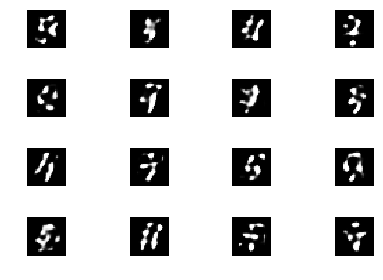

Epoch 131:
	D Network Loss: 0.630 Accuracy: 0.752
	Overall A Loss: 0.717 Accuracy: 0.445
Epoch 132:
	D Network Loss: 0.703 Accuracy: 0.504
	Overall A Loss: 1.108 Accuracy: 0.000
Epoch 133:
	D Network Loss: 0.640 Accuracy: 0.689
	Overall A Loss: 0.716 Accuracy: 0.406
Epoch 134:
	D Network Loss: 0.695 Accuracy: 0.508
	Overall A Loss: 1.119 Accuracy: 0.000
Epoch 135:
	D Network Loss: 0.634 Accuracy: 0.709
	Overall A Loss: 0.709 Accuracy: 0.477
Epoch 136:
	D Network Loss: 0.717 Accuracy: 0.500
	Overall A Loss: 1.158 Accuracy: 0.000
Epoch 137:
	D Network Loss: 0.650 Accuracy: 0.648
	Overall A Loss: 0.706 Accuracy: 0.441
Epoch 138:
	D Network Loss: 0.699 Accuracy: 0.504
	Overall A Loss: 1.060 Accuracy: 0.004
Epoch 139:
	D Network Loss: 0.646 Accuracy: 0.662
	Overall A Loss: 0.744 Accuracy: 0.352
Epoch 140:
	D Network Loss: 0.698 Accuracy: 0.506
	Overall A Loss: 1.048 Accuracy: 0.000


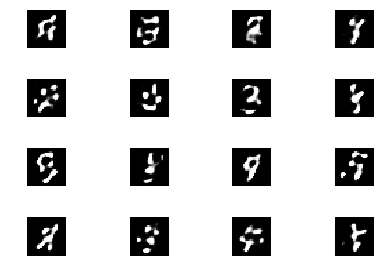

Epoch 141:
	D Network Loss: 0.644 Accuracy: 0.695
	Overall A Loss: 0.783 Accuracy: 0.219
Epoch 142:
	D Network Loss: 0.679 Accuracy: 0.521
	Overall A Loss: 1.065 Accuracy: 0.000
Epoch 143:
	D Network Loss: 0.640 Accuracy: 0.719
	Overall A Loss: 0.771 Accuracy: 0.238
Epoch 144:
	D Network Loss: 0.691 Accuracy: 0.531
	Overall A Loss: 1.125 Accuracy: 0.000
Epoch 145:
	D Network Loss: 0.648 Accuracy: 0.656
	Overall A Loss: 0.724 Accuracy: 0.406
Epoch 146:
	D Network Loss: 0.705 Accuracy: 0.504
	Overall A Loss: 1.170 Accuracy: 0.000
Epoch 147:
	D Network Loss: 0.654 Accuracy: 0.623
	Overall A Loss: 0.653 Accuracy: 0.609
Epoch 148:
	D Network Loss: 0.727 Accuracy: 0.510
	Overall A Loss: 1.140 Accuracy: 0.000
Epoch 149:
	D Network Loss: 0.645 Accuracy: 0.641
	Overall A Loss: 0.690 Accuracy: 0.492
Epoch 150:
	D Network Loss: 0.712 Accuracy: 0.504
	Overall A Loss: 1.064 Accuracy: 0.000


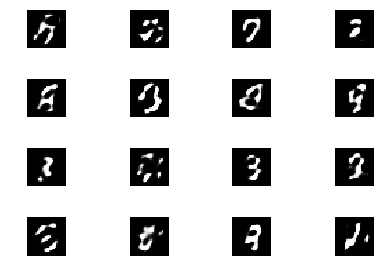

Epoch 151:
	D Network Loss: 0.656 Accuracy: 0.627
	Overall A Loss: 0.719 Accuracy: 0.430
Epoch 152:
	D Network Loss: 0.687 Accuracy: 0.518
	Overall A Loss: 1.022 Accuracy: 0.004
Epoch 153:
	D Network Loss: 0.641 Accuracy: 0.703
	Overall A Loss: 0.752 Accuracy: 0.312
Epoch 154:
	D Network Loss: 0.696 Accuracy: 0.518
	Overall A Loss: 1.054 Accuracy: 0.004
Epoch 155:
	D Network Loss: 0.648 Accuracy: 0.658
	Overall A Loss: 0.717 Accuracy: 0.395
Epoch 156:
	D Network Loss: 0.691 Accuracy: 0.510
	Overall A Loss: 1.076 Accuracy: 0.004
Epoch 157:
	D Network Loss: 0.664 Accuracy: 0.598
	Overall A Loss: 0.736 Accuracy: 0.375
Epoch 158:
	D Network Loss: 0.705 Accuracy: 0.508
	Overall A Loss: 1.121 Accuracy: 0.000
Epoch 159:
	D Network Loss: 0.649 Accuracy: 0.646
	Overall A Loss: 0.678 Accuracy: 0.512
Epoch 160:
	D Network Loss: 0.707 Accuracy: 0.502
	Overall A Loss: 1.103 Accuracy: 0.000


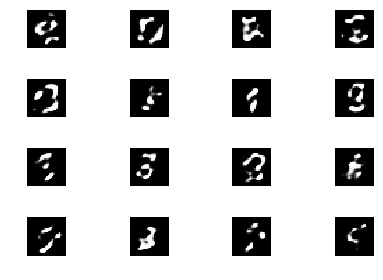

Epoch 161:
	D Network Loss: 0.656 Accuracy: 0.645
	Overall A Loss: 0.685 Accuracy: 0.566
Epoch 162:
	D Network Loss: 0.741 Accuracy: 0.506
	Overall A Loss: 1.054 Accuracy: 0.000
Epoch 163:
	D Network Loss: 0.656 Accuracy: 0.645
	Overall A Loss: 0.713 Accuracy: 0.453
Epoch 164:
	D Network Loss: 0.692 Accuracy: 0.521
	Overall A Loss: 0.971 Accuracy: 0.016
Epoch 165:
	D Network Loss: 0.652 Accuracy: 0.662
	Overall A Loss: 0.795 Accuracy: 0.191
Epoch 166:
	D Network Loss: 0.697 Accuracy: 0.518
	Overall A Loss: 1.081 Accuracy: 0.008
Epoch 167:
	D Network Loss: 0.667 Accuracy: 0.615
	Overall A Loss: 0.685 Accuracy: 0.520
Epoch 168:
	D Network Loss: 0.699 Accuracy: 0.512
	Overall A Loss: 1.045 Accuracy: 0.000
Epoch 169:
	D Network Loss: 0.672 Accuracy: 0.596
	Overall A Loss: 0.747 Accuracy: 0.348
Epoch 170:
	D Network Loss: 0.699 Accuracy: 0.516
	Overall A Loss: 1.117 Accuracy: 0.000


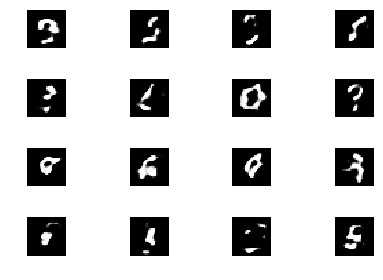

Epoch 171:
	D Network Loss: 0.665 Accuracy: 0.615
	Overall A Loss: 0.676 Accuracy: 0.559
Epoch 172:
	D Network Loss: 0.722 Accuracy: 0.502
	Overall A Loss: 1.100 Accuracy: 0.000
Epoch 173:
	D Network Loss: 0.666 Accuracy: 0.596
	Overall A Loss: 0.693 Accuracy: 0.520
Epoch 174:
	D Network Loss: 0.714 Accuracy: 0.508
	Overall A Loss: 1.074 Accuracy: 0.000
Epoch 175:
	D Network Loss: 0.667 Accuracy: 0.568
	Overall A Loss: 0.691 Accuracy: 0.523
Epoch 176:
	D Network Loss: 0.719 Accuracy: 0.504
	Overall A Loss: 0.995 Accuracy: 0.016
Epoch 177:
	D Network Loss: 0.667 Accuracy: 0.570
	Overall A Loss: 0.742 Accuracy: 0.348
Epoch 178:
	D Network Loss: 0.697 Accuracy: 0.523
	Overall A Loss: 0.957 Accuracy: 0.016
Epoch 179:
	D Network Loss: 0.662 Accuracy: 0.652
	Overall A Loss: 0.797 Accuracy: 0.191
Epoch 180:
	D Network Loss: 0.682 Accuracy: 0.529
	Overall A Loss: 0.970 Accuracy: 0.023


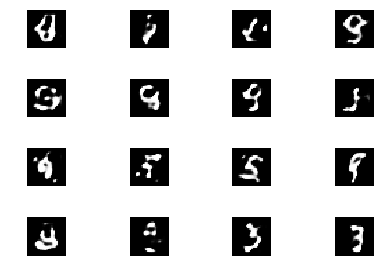

Epoch 181:
	D Network Loss: 0.656 Accuracy: 0.631
	Overall A Loss: 0.775 Accuracy: 0.281
Epoch 182:
	D Network Loss: 0.688 Accuracy: 0.521
	Overall A Loss: 1.076 Accuracy: 0.004
Epoch 183:
	D Network Loss: 0.660 Accuracy: 0.615
	Overall A Loss: 0.653 Accuracy: 0.617
Epoch 184:
	D Network Loss: 0.726 Accuracy: 0.502
	Overall A Loss: 1.122 Accuracy: 0.000
Epoch 185:
	D Network Loss: 0.675 Accuracy: 0.557
	Overall A Loss: 0.669 Accuracy: 0.602
Epoch 186:
	D Network Loss: 0.719 Accuracy: 0.506
	Overall A Loss: 0.949 Accuracy: 0.016
Epoch 187:
	D Network Loss: 0.656 Accuracy: 0.676
	Overall A Loss: 0.727 Accuracy: 0.398
Epoch 188:
	D Network Loss: 0.689 Accuracy: 0.518
	Overall A Loss: 0.970 Accuracy: 0.008
Epoch 189:
	D Network Loss: 0.670 Accuracy: 0.600
	Overall A Loss: 0.782 Accuracy: 0.258
Epoch 190:
	D Network Loss: 0.676 Accuracy: 0.527
	Overall A Loss: 0.924 Accuracy: 0.051


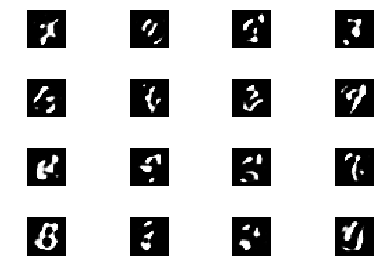

Epoch 191:
	D Network Loss: 0.659 Accuracy: 0.611
	Overall A Loss: 0.800 Accuracy: 0.211
Epoch 192:
	D Network Loss: 0.692 Accuracy: 0.523
	Overall A Loss: 0.995 Accuracy: 0.008
Epoch 193:
	D Network Loss: 0.665 Accuracy: 0.625
	Overall A Loss: 0.768 Accuracy: 0.285
Epoch 194:
	D Network Loss: 0.697 Accuracy: 0.520
	Overall A Loss: 1.098 Accuracy: 0.000
Epoch 195:
	D Network Loss: 0.677 Accuracy: 0.564
	Overall A Loss: 0.694 Accuracy: 0.516
Epoch 196:
	D Network Loss: 0.727 Accuracy: 0.504
	Overall A Loss: 1.032 Accuracy: 0.004
Epoch 197:
	D Network Loss: 0.679 Accuracy: 0.557
	Overall A Loss: 0.707 Accuracy: 0.441
Epoch 198:
	D Network Loss: 0.700 Accuracy: 0.518
	Overall A Loss: 1.013 Accuracy: 0.004
Epoch 199:
	D Network Loss: 0.659 Accuracy: 0.639
	Overall A Loss: 0.734 Accuracy: 0.348
Epoch 200:
	D Network Loss: 0.690 Accuracy: 0.502
	Overall A Loss: 0.954 Accuracy: 0.004


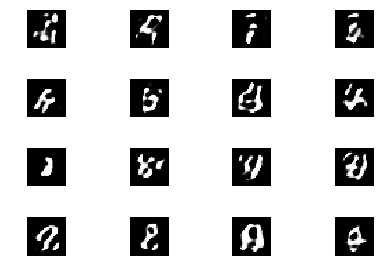

Epoch 201:
	D Network Loss: 0.667 Accuracy: 0.629
	Overall A Loss: 0.760 Accuracy: 0.293
Epoch 202:
	D Network Loss: 0.694 Accuracy: 0.518
	Overall A Loss: 1.008 Accuracy: 0.012
Epoch 203:
	D Network Loss: 0.662 Accuracy: 0.643
	Overall A Loss: 0.751 Accuracy: 0.285
Epoch 204:
	D Network Loss: 0.690 Accuracy: 0.521
	Overall A Loss: 1.002 Accuracy: 0.020
Epoch 205:
	D Network Loss: 0.670 Accuracy: 0.572
	Overall A Loss: 0.762 Accuracy: 0.293
Epoch 206:
	D Network Loss: 0.679 Accuracy: 0.527
	Overall A Loss: 0.946 Accuracy: 0.012
Epoch 207:
	D Network Loss: 0.668 Accuracy: 0.600
	Overall A Loss: 0.803 Accuracy: 0.207
Epoch 208:
	D Network Loss: 0.689 Accuracy: 0.521
	Overall A Loss: 0.998 Accuracy: 0.012
Epoch 209:
	D Network Loss: 0.670 Accuracy: 0.617
	Overall A Loss: 0.773 Accuracy: 0.273
Epoch 210:
	D Network Loss: 0.697 Accuracy: 0.521
	Overall A Loss: 0.997 Accuracy: 0.004


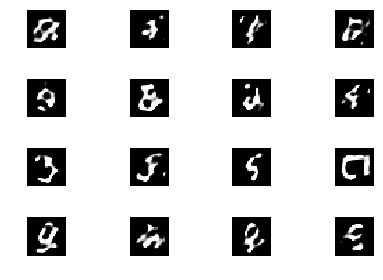

Epoch 211:
	D Network Loss: 0.661 Accuracy: 0.646
	Overall A Loss: 0.731 Accuracy: 0.383
Epoch 212:
	D Network Loss: 0.708 Accuracy: 0.516
	Overall A Loss: 1.182 Accuracy: 0.000
Epoch 213:
	D Network Loss: 0.677 Accuracy: 0.533
	Overall A Loss: 0.648 Accuracy: 0.652
Epoch 214:
	D Network Loss: 0.756 Accuracy: 0.496
	Overall A Loss: 0.965 Accuracy: 0.012
Epoch 215:
	D Network Loss: 0.673 Accuracy: 0.596
	Overall A Loss: 0.760 Accuracy: 0.258
Epoch 216:
	D Network Loss: 0.689 Accuracy: 0.539
	Overall A Loss: 0.984 Accuracy: 0.023
Epoch 217:
	D Network Loss: 0.664 Accuracy: 0.631
	Overall A Loss: 0.751 Accuracy: 0.301
Epoch 218:
	D Network Loss: 0.697 Accuracy: 0.521
	Overall A Loss: 0.943 Accuracy: 0.016
Epoch 219:
	D Network Loss: 0.671 Accuracy: 0.588
	Overall A Loss: 0.751 Accuracy: 0.293
Epoch 220:
	D Network Loss: 0.692 Accuracy: 0.516
	Overall A Loss: 0.983 Accuracy: 0.016


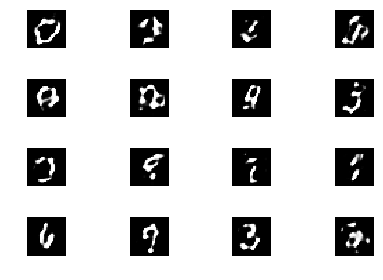

Epoch 221:
	D Network Loss: 0.665 Accuracy: 0.613
	Overall A Loss: 0.724 Accuracy: 0.418
Epoch 222:
	D Network Loss: 0.704 Accuracy: 0.510
	Overall A Loss: 1.050 Accuracy: 0.000
Epoch 223:
	D Network Loss: 0.670 Accuracy: 0.592
	Overall A Loss: 0.710 Accuracy: 0.434
Epoch 224:
	D Network Loss: 0.717 Accuracy: 0.504
	Overall A Loss: 1.041 Accuracy: 0.016
Epoch 225:
	D Network Loss: 0.686 Accuracy: 0.539
	Overall A Loss: 0.735 Accuracy: 0.348
Epoch 226:
	D Network Loss: 0.696 Accuracy: 0.533
	Overall A Loss: 0.988 Accuracy: 0.008
Epoch 227:
	D Network Loss: 0.688 Accuracy: 0.531
	Overall A Loss: 0.811 Accuracy: 0.160
Epoch 228:
	D Network Loss: 0.706 Accuracy: 0.504
	Overall A Loss: 0.888 Accuracy: 0.039
Epoch 229:
	D Network Loss: 0.673 Accuracy: 0.584
	Overall A Loss: 0.762 Accuracy: 0.309
Epoch 230:
	D Network Loss: 0.698 Accuracy: 0.531
	Overall A Loss: 1.031 Accuracy: 0.004


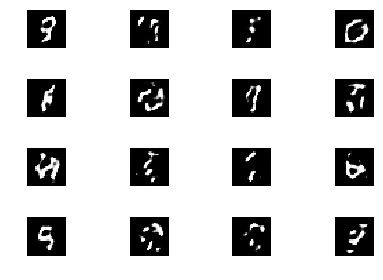

Epoch 231:
	D Network Loss: 0.677 Accuracy: 0.561
	Overall A Loss: 0.670 Accuracy: 0.578
Epoch 232:
	D Network Loss: 0.700 Accuracy: 0.504
	Overall A Loss: 0.960 Accuracy: 0.008
Epoch 233:
	D Network Loss: 0.674 Accuracy: 0.598
	Overall A Loss: 0.745 Accuracy: 0.336
Epoch 234:
	D Network Loss: 0.700 Accuracy: 0.525
	Overall A Loss: 0.981 Accuracy: 0.012
Epoch 235:
	D Network Loss: 0.668 Accuracy: 0.607
	Overall A Loss: 0.732 Accuracy: 0.387
Epoch 236:
	D Network Loss: 0.692 Accuracy: 0.514
	Overall A Loss: 1.021 Accuracy: 0.000
Epoch 237:
	D Network Loss: 0.665 Accuracy: 0.631
	Overall A Loss: 0.695 Accuracy: 0.516
Epoch 238:
	D Network Loss: 0.709 Accuracy: 0.502
	Overall A Loss: 1.012 Accuracy: 0.008
Epoch 239:
	D Network Loss: 0.674 Accuracy: 0.586
	Overall A Loss: 0.744 Accuracy: 0.336
Epoch 240:
	D Network Loss: 0.699 Accuracy: 0.537
	Overall A Loss: 0.971 Accuracy: 0.008


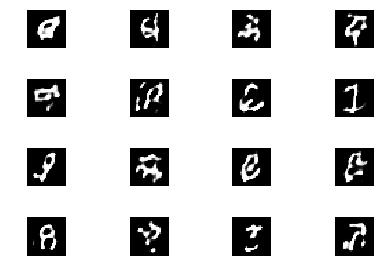

Epoch 241:
	D Network Loss: 0.678 Accuracy: 0.584
	Overall A Loss: 0.742 Accuracy: 0.355
Epoch 242:
	D Network Loss: 0.693 Accuracy: 0.520
	Overall A Loss: 0.999 Accuracy: 0.008
Epoch 243:
	D Network Loss: 0.666 Accuracy: 0.635
	Overall A Loss: 0.690 Accuracy: 0.527
Epoch 244:
	D Network Loss: 0.704 Accuracy: 0.506
	Overall A Loss: 1.057 Accuracy: 0.000
Epoch 245:
	D Network Loss: 0.675 Accuracy: 0.582
	Overall A Loss: 0.691 Accuracy: 0.500
Epoch 246:
	D Network Loss: 0.712 Accuracy: 0.512
	Overall A Loss: 0.991 Accuracy: 0.008
Epoch 247:
	D Network Loss: 0.669 Accuracy: 0.598
	Overall A Loss: 0.743 Accuracy: 0.305
Epoch 248:
	D Network Loss: 0.691 Accuracy: 0.533
	Overall A Loss: 0.970 Accuracy: 0.008
Epoch 249:
	D Network Loss: 0.682 Accuracy: 0.539
	Overall A Loss: 0.719 Accuracy: 0.418
Epoch 250:
	D Network Loss: 0.694 Accuracy: 0.525
	Overall A Loss: 0.977 Accuracy: 0.008


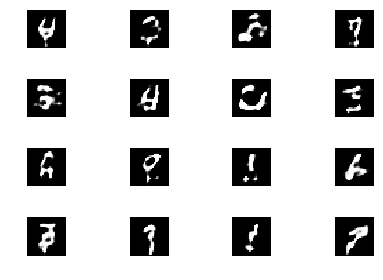

Epoch 251:
	D Network Loss: 0.666 Accuracy: 0.605
	Overall A Loss: 0.712 Accuracy: 0.418
Epoch 252:
	D Network Loss: 0.689 Accuracy: 0.520
	Overall A Loss: 0.969 Accuracy: 0.023
Epoch 253:
	D Network Loss: 0.678 Accuracy: 0.586
	Overall A Loss: 0.751 Accuracy: 0.320
Epoch 254:
	D Network Loss: 0.683 Accuracy: 0.535
	Overall A Loss: 0.991 Accuracy: 0.016
Epoch 255:
	D Network Loss: 0.671 Accuracy: 0.594
	Overall A Loss: 0.790 Accuracy: 0.273
Epoch 256:
	D Network Loss: 0.696 Accuracy: 0.531
	Overall A Loss: 1.013 Accuracy: 0.004
Epoch 257:
	D Network Loss: 0.670 Accuracy: 0.586
	Overall A Loss: 0.711 Accuracy: 0.488
Epoch 258:
	D Network Loss: 0.706 Accuracy: 0.525
	Overall A Loss: 1.084 Accuracy: 0.004
Epoch 259:
	D Network Loss: 0.675 Accuracy: 0.562
	Overall A Loss: 0.684 Accuracy: 0.582
Epoch 260:
	D Network Loss: 0.702 Accuracy: 0.508
	Overall A Loss: 1.061 Accuracy: 0.000


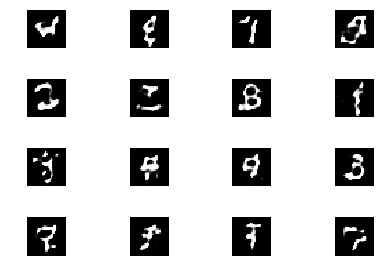

Epoch 261:
	D Network Loss: 0.664 Accuracy: 0.623
	Overall A Loss: 0.694 Accuracy: 0.512
Epoch 262:
	D Network Loss: 0.695 Accuracy: 0.514
	Overall A Loss: 0.968 Accuracy: 0.016
Epoch 263:
	D Network Loss: 0.672 Accuracy: 0.594
	Overall A Loss: 0.762 Accuracy: 0.309
Epoch 264:
	D Network Loss: 0.688 Accuracy: 0.541
	Overall A Loss: 0.977 Accuracy: 0.020
Epoch 265:
	D Network Loss: 0.677 Accuracy: 0.600
	Overall A Loss: 0.736 Accuracy: 0.418
Epoch 266:
	D Network Loss: 0.709 Accuracy: 0.518
	Overall A Loss: 1.031 Accuracy: 0.008
Epoch 267:
	D Network Loss: 0.676 Accuracy: 0.576
	Overall A Loss: 0.711 Accuracy: 0.484
Epoch 268:
	D Network Loss: 0.693 Accuracy: 0.520
	Overall A Loss: 0.949 Accuracy: 0.016
Epoch 269:
	D Network Loss: 0.688 Accuracy: 0.529
	Overall A Loss: 0.747 Accuracy: 0.336
Epoch 270:
	D Network Loss: 0.672 Accuracy: 0.535
	Overall A Loss: 0.923 Accuracy: 0.043


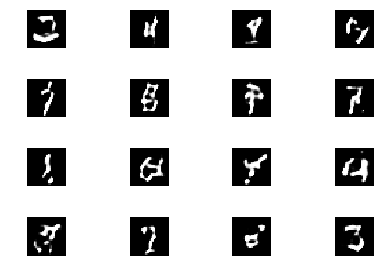

Epoch 271:
	D Network Loss: 0.676 Accuracy: 0.574
	Overall A Loss: 0.836 Accuracy: 0.129
Epoch 272:
	D Network Loss: 0.679 Accuracy: 0.559
	Overall A Loss: 0.894 Accuracy: 0.078
Epoch 273:
	D Network Loss: 0.670 Accuracy: 0.570
	Overall A Loss: 0.887 Accuracy: 0.074
Epoch 274:
	D Network Loss: 0.682 Accuracy: 0.557
	Overall A Loss: 0.910 Accuracy: 0.062
Epoch 275:
	D Network Loss: 0.672 Accuracy: 0.582
	Overall A Loss: 0.900 Accuracy: 0.086
Epoch 276:
	D Network Loss: 0.682 Accuracy: 0.553
	Overall A Loss: 0.928 Accuracy: 0.047
Epoch 277:
	D Network Loss: 0.685 Accuracy: 0.564
	Overall A Loss: 0.882 Accuracy: 0.098
Epoch 278:
	D Network Loss: 0.680 Accuracy: 0.549
	Overall A Loss: 1.042 Accuracy: 0.008
Epoch 279:
	D Network Loss: 0.666 Accuracy: 0.594
	Overall A Loss: 0.679 Accuracy: 0.598
Epoch 280:
	D Network Loss: 0.720 Accuracy: 0.502
	Overall A Loss: 1.247 Accuracy: 0.000


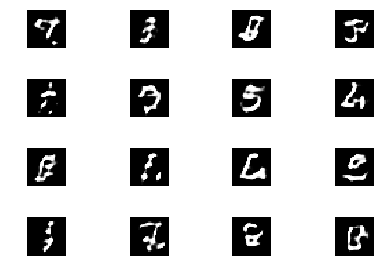

Epoch 281:
	D Network Loss: 0.685 Accuracy: 0.539
	Overall A Loss: 0.626 Accuracy: 0.734
Epoch 282:
	D Network Loss: 0.739 Accuracy: 0.500
	Overall A Loss: 1.005 Accuracy: 0.012
Epoch 283:
	D Network Loss: 0.663 Accuracy: 0.609
	Overall A Loss: 0.708 Accuracy: 0.465
Epoch 284:
	D Network Loss: 0.723 Accuracy: 0.504
	Overall A Loss: 1.027 Accuracy: 0.008
Epoch 285:
	D Network Loss: 0.681 Accuracy: 0.562
	Overall A Loss: 0.729 Accuracy: 0.387
Epoch 286:
	D Network Loss: 0.699 Accuracy: 0.518
	Overall A Loss: 0.866 Accuracy: 0.102
Epoch 287:
	D Network Loss: 0.679 Accuracy: 0.547
	Overall A Loss: 0.827 Accuracy: 0.152
Epoch 288:
	D Network Loss: 0.680 Accuracy: 0.576
	Overall A Loss: 0.851 Accuracy: 0.137
Epoch 289:
	D Network Loss: 0.669 Accuracy: 0.598
	Overall A Loss: 0.832 Accuracy: 0.168
Epoch 290:
	D Network Loss: 0.679 Accuracy: 0.580
	Overall A Loss: 0.904 Accuracy: 0.047


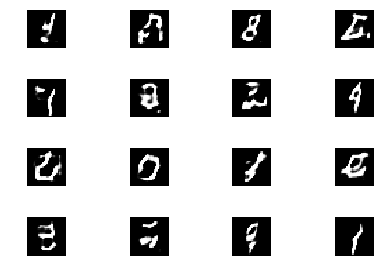

Epoch 291:
	D Network Loss: 0.677 Accuracy: 0.566
	Overall A Loss: 0.804 Accuracy: 0.219
Epoch 292:
	D Network Loss: 0.685 Accuracy: 0.549
	Overall A Loss: 0.952 Accuracy: 0.043
Epoch 293:
	D Network Loss: 0.676 Accuracy: 0.590
	Overall A Loss: 0.790 Accuracy: 0.223
Epoch 294:
	D Network Loss: 0.687 Accuracy: 0.551
	Overall A Loss: 1.023 Accuracy: 0.004
Epoch 295:
	D Network Loss: 0.661 Accuracy: 0.615
	Overall A Loss: 0.746 Accuracy: 0.371
Epoch 296:
	D Network Loss: 0.703 Accuracy: 0.504
	Overall A Loss: 1.104 Accuracy: 0.004
Epoch 297:
	D Network Loss: 0.667 Accuracy: 0.578
	Overall A Loss: 0.678 Accuracy: 0.578
Epoch 298:
	D Network Loss: 0.700 Accuracy: 0.521
	Overall A Loss: 1.095 Accuracy: 0.008
Epoch 299:
	D Network Loss: 0.675 Accuracy: 0.545
	Overall A Loss: 0.707 Accuracy: 0.516
Epoch 300:
	D Network Loss: 0.704 Accuracy: 0.527
	Overall A Loss: 0.981 Accuracy: 0.016


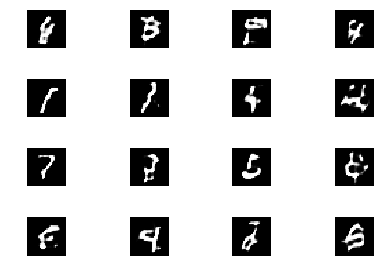

Epoch 301:
	D Network Loss: 0.670 Accuracy: 0.598
	Overall A Loss: 0.758 Accuracy: 0.316
Epoch 302:
	D Network Loss: 0.699 Accuracy: 0.518
	Overall A Loss: 0.959 Accuracy: 0.035
Epoch 303:
	D Network Loss: 0.668 Accuracy: 0.586
	Overall A Loss: 0.758 Accuracy: 0.301
Epoch 304:
	D Network Loss: 0.698 Accuracy: 0.535
	Overall A Loss: 1.022 Accuracy: 0.012
Epoch 305:
	D Network Loss: 0.669 Accuracy: 0.607
	Overall A Loss: 0.724 Accuracy: 0.441
Epoch 306:
	D Network Loss: 0.719 Accuracy: 0.525
	Overall A Loss: 0.984 Accuracy: 0.023
Epoch 307:
	D Network Loss: 0.674 Accuracy: 0.613
	Overall A Loss: 0.735 Accuracy: 0.406
Epoch 308:
	D Network Loss: 0.697 Accuracy: 0.521
	Overall A Loss: 0.988 Accuracy: 0.008
Epoch 309:
	D Network Loss: 0.676 Accuracy: 0.584
	Overall A Loss: 0.723 Accuracy: 0.465
Epoch 310:
	D Network Loss: 0.695 Accuracy: 0.531
	Overall A Loss: 0.985 Accuracy: 0.012


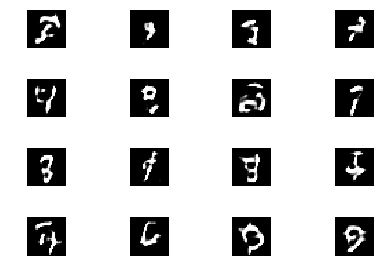

Epoch 311:
	D Network Loss: 0.673 Accuracy: 0.584
	Overall A Loss: 0.773 Accuracy: 0.285
Epoch 312:
	D Network Loss: 0.689 Accuracy: 0.551
	Overall A Loss: 0.949 Accuracy: 0.039
Epoch 313:
	D Network Loss: 0.671 Accuracy: 0.619
	Overall A Loss: 0.802 Accuracy: 0.223
Epoch 314:
	D Network Loss: 0.675 Accuracy: 0.580
	Overall A Loss: 0.938 Accuracy: 0.023
Epoch 315:
	D Network Loss: 0.662 Accuracy: 0.598
	Overall A Loss: 0.786 Accuracy: 0.238
Epoch 316:
	D Network Loss: 0.697 Accuracy: 0.551
	Overall A Loss: 1.064 Accuracy: 0.004
Epoch 317:
	D Network Loss: 0.671 Accuracy: 0.576
	Overall A Loss: 0.738 Accuracy: 0.414
Epoch 318:
	D Network Loss: 0.732 Accuracy: 0.498
	Overall A Loss: 1.043 Accuracy: 0.020
Epoch 319:
	D Network Loss: 0.670 Accuracy: 0.578
	Overall A Loss: 0.732 Accuracy: 0.402
Epoch 320:
	D Network Loss: 0.705 Accuracy: 0.521
	Overall A Loss: 1.057 Accuracy: 0.008


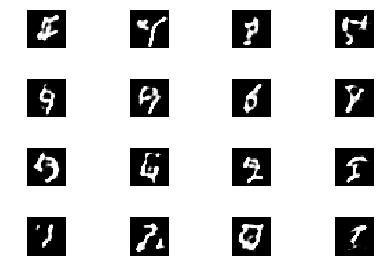

Epoch 321:
	D Network Loss: 0.678 Accuracy: 0.576
	Overall A Loss: 0.667 Accuracy: 0.590
Epoch 322:
	D Network Loss: 0.707 Accuracy: 0.518
	Overall A Loss: 0.950 Accuracy: 0.035
Epoch 323:
	D Network Loss: 0.667 Accuracy: 0.600
	Overall A Loss: 0.750 Accuracy: 0.340
Epoch 324:
	D Network Loss: 0.691 Accuracy: 0.547
	Overall A Loss: 0.960 Accuracy: 0.023
Epoch 325:
	D Network Loss: 0.662 Accuracy: 0.623
	Overall A Loss: 0.783 Accuracy: 0.262
Epoch 326:
	D Network Loss: 0.676 Accuracy: 0.549
	Overall A Loss: 0.969 Accuracy: 0.016
Epoch 327:
	D Network Loss: 0.664 Accuracy: 0.582
	Overall A Loss: 0.809 Accuracy: 0.242
Epoch 328:
	D Network Loss: 0.688 Accuracy: 0.561
	Overall A Loss: 0.973 Accuracy: 0.035
Epoch 329:
	D Network Loss: 0.673 Accuracy: 0.561
	Overall A Loss: 0.792 Accuracy: 0.277
Epoch 330:
	D Network Loss: 0.680 Accuracy: 0.543
	Overall A Loss: 1.040 Accuracy: 0.027


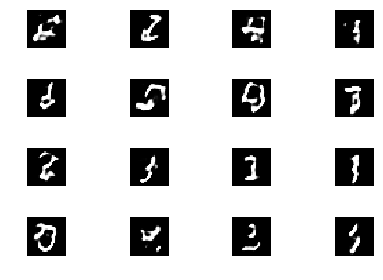

Epoch 331:
	D Network Loss: 0.665 Accuracy: 0.611
	Overall A Loss: 0.748 Accuracy: 0.363
Epoch 332:
	D Network Loss: 0.689 Accuracy: 0.518
	Overall A Loss: 1.091 Accuracy: 0.020
Epoch 333:
	D Network Loss: 0.682 Accuracy: 0.551
	Overall A Loss: 0.705 Accuracy: 0.500
Epoch 334:
	D Network Loss: 0.716 Accuracy: 0.508
	Overall A Loss: 1.117 Accuracy: 0.012
Epoch 335:
	D Network Loss: 0.668 Accuracy: 0.588
	Overall A Loss: 0.698 Accuracy: 0.477
Epoch 336:
	D Network Loss: 0.710 Accuracy: 0.502
	Overall A Loss: 1.023 Accuracy: 0.027
Epoch 337:
	D Network Loss: 0.681 Accuracy: 0.539
	Overall A Loss: 0.762 Accuracy: 0.297
Epoch 338:
	D Network Loss: 0.685 Accuracy: 0.549
	Overall A Loss: 0.913 Accuracy: 0.047
Epoch 339:
	D Network Loss: 0.679 Accuracy: 0.578
	Overall A Loss: 0.895 Accuracy: 0.105
Epoch 340:
	D Network Loss: 0.696 Accuracy: 0.516
	Overall A Loss: 0.863 Accuracy: 0.133


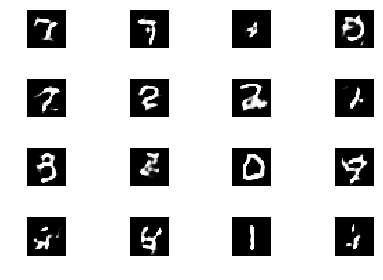

Epoch 341:
	D Network Loss: 0.679 Accuracy: 0.553
	Overall A Loss: 0.897 Accuracy: 0.082
Epoch 342:
	D Network Loss: 0.679 Accuracy: 0.568
	Overall A Loss: 0.830 Accuracy: 0.184
Epoch 343:
	D Network Loss: 0.682 Accuracy: 0.555
	Overall A Loss: 0.964 Accuracy: 0.031
Epoch 344:
	D Network Loss: 0.671 Accuracy: 0.574
	Overall A Loss: 0.820 Accuracy: 0.195
Epoch 345:
	D Network Loss: 0.686 Accuracy: 0.535
	Overall A Loss: 1.052 Accuracy: 0.016
Epoch 346:
	D Network Loss: 0.681 Accuracy: 0.543
	Overall A Loss: 0.695 Accuracy: 0.508
Epoch 347:
	D Network Loss: 0.700 Accuracy: 0.520
	Overall A Loss: 1.131 Accuracy: 0.004
Epoch 348:
	D Network Loss: 0.683 Accuracy: 0.531
	Overall A Loss: 0.657 Accuracy: 0.648
Epoch 349:
	D Network Loss: 0.709 Accuracy: 0.516
	Overall A Loss: 1.085 Accuracy: 0.004
Epoch 350:
	D Network Loss: 0.678 Accuracy: 0.570
	Overall A Loss: 0.723 Accuracy: 0.426


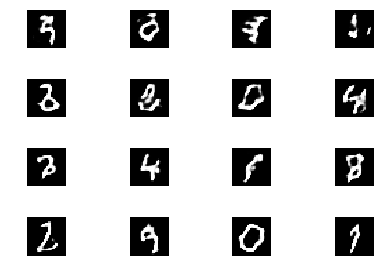

Epoch 351:
	D Network Loss: 0.700 Accuracy: 0.512
	Overall A Loss: 0.958 Accuracy: 0.051
Epoch 352:
	D Network Loss: 0.674 Accuracy: 0.588
	Overall A Loss: 0.798 Accuracy: 0.195
Epoch 353:
	D Network Loss: 0.682 Accuracy: 0.555
	Overall A Loss: 0.890 Accuracy: 0.078
Epoch 354:
	D Network Loss: 0.686 Accuracy: 0.551
	Overall A Loss: 0.842 Accuracy: 0.109
Epoch 355:
	D Network Loss: 0.689 Accuracy: 0.541
	Overall A Loss: 0.917 Accuracy: 0.055
Epoch 356:
	D Network Loss: 0.676 Accuracy: 0.578
	Overall A Loss: 0.866 Accuracy: 0.109
Epoch 357:
	D Network Loss: 0.680 Accuracy: 0.586
	Overall A Loss: 0.875 Accuracy: 0.102
Epoch 358:
	D Network Loss: 0.676 Accuracy: 0.568
	Overall A Loss: 0.892 Accuracy: 0.094
Epoch 359:
	D Network Loss: 0.685 Accuracy: 0.549
	Overall A Loss: 0.872 Accuracy: 0.141
Epoch 360:
	D Network Loss: 0.683 Accuracy: 0.549
	Overall A Loss: 0.888 Accuracy: 0.102


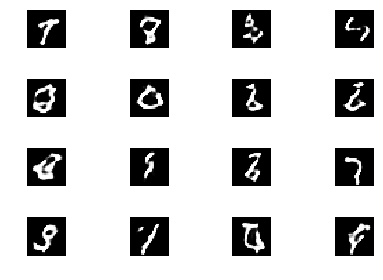

Epoch 361:
	D Network Loss: 0.681 Accuracy: 0.553
	Overall A Loss: 0.969 Accuracy: 0.020
Epoch 362:
	D Network Loss: 0.678 Accuracy: 0.584
	Overall A Loss: 0.793 Accuracy: 0.234
Epoch 363:
	D Network Loss: 0.695 Accuracy: 0.541
	Overall A Loss: 1.148 Accuracy: 0.004
Epoch 364:
	D Network Loss: 0.683 Accuracy: 0.549
	Overall A Loss: 0.630 Accuracy: 0.691
Epoch 365:
	D Network Loss: 0.741 Accuracy: 0.510
	Overall A Loss: 1.180 Accuracy: 0.004
Epoch 366:
	D Network Loss: 0.687 Accuracy: 0.541
	Overall A Loss: 0.646 Accuracy: 0.648
Epoch 367:
	D Network Loss: 0.714 Accuracy: 0.498
	Overall A Loss: 0.930 Accuracy: 0.035
Epoch 368:
	D Network Loss: 0.669 Accuracy: 0.609
	Overall A Loss: 0.763 Accuracy: 0.316
Epoch 369:
	D Network Loss: 0.679 Accuracy: 0.559
	Overall A Loss: 0.856 Accuracy: 0.117
Epoch 370:
	D Network Loss: 0.686 Accuracy: 0.551
	Overall A Loss: 0.800 Accuracy: 0.250


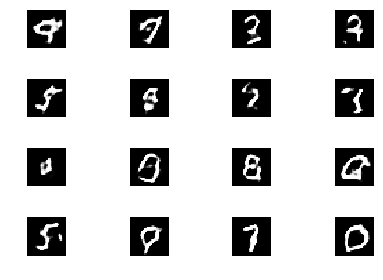

Epoch 371:
	D Network Loss: 0.680 Accuracy: 0.533
	Overall A Loss: 0.866 Accuracy: 0.141
Epoch 372:
	D Network Loss: 0.669 Accuracy: 0.594
	Overall A Loss: 0.888 Accuracy: 0.098
Epoch 373:
	D Network Loss: 0.684 Accuracy: 0.555
	Overall A Loss: 0.868 Accuracy: 0.129
Epoch 374:
	D Network Loss: 0.690 Accuracy: 0.525
	Overall A Loss: 0.948 Accuracy: 0.031
Epoch 375:
	D Network Loss: 0.679 Accuracy: 0.549
	Overall A Loss: 0.866 Accuracy: 0.152
Epoch 376:
	D Network Loss: 0.690 Accuracy: 0.543
	Overall A Loss: 1.051 Accuracy: 0.008
Epoch 377:
	D Network Loss: 0.687 Accuracy: 0.537
	Overall A Loss: 0.701 Accuracy: 0.477
Epoch 378:
	D Network Loss: 0.708 Accuracy: 0.512
	Overall A Loss: 1.034 Accuracy: 0.012
Epoch 379:
	D Network Loss: 0.691 Accuracy: 0.506
	Overall A Loss: 0.725 Accuracy: 0.445
Epoch 380:
	D Network Loss: 0.697 Accuracy: 0.525
	Overall A Loss: 0.989 Accuracy: 0.027


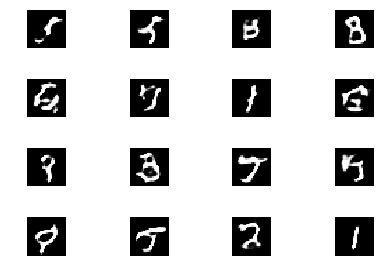

Epoch 381:
	D Network Loss: 0.677 Accuracy: 0.566
	Overall A Loss: 0.755 Accuracy: 0.320
Epoch 382:
	D Network Loss: 0.686 Accuracy: 0.559
	Overall A Loss: 0.970 Accuracy: 0.043
Epoch 383:
	D Network Loss: 0.677 Accuracy: 0.576
	Overall A Loss: 0.704 Accuracy: 0.477
Epoch 384:
	D Network Loss: 0.694 Accuracy: 0.525
	Overall A Loss: 0.988 Accuracy: 0.008
Epoch 385:
	D Network Loss: 0.683 Accuracy: 0.553
	Overall A Loss: 0.714 Accuracy: 0.438
Epoch 386:
	D Network Loss: 0.691 Accuracy: 0.539
	Overall A Loss: 0.936 Accuracy: 0.043
Epoch 387:
	D Network Loss: 0.676 Accuracy: 0.562
	Overall A Loss: 0.793 Accuracy: 0.238
Epoch 388:
	D Network Loss: 0.690 Accuracy: 0.539
	Overall A Loss: 0.929 Accuracy: 0.062
Epoch 389:
	D Network Loss: 0.669 Accuracy: 0.588
	Overall A Loss: 0.785 Accuracy: 0.227
Epoch 390:
	D Network Loss: 0.692 Accuracy: 0.529
	Overall A Loss: 0.978 Accuracy: 0.023


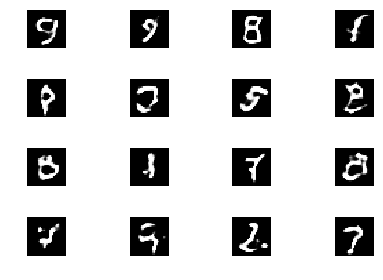

Epoch 391:
	D Network Loss: 0.677 Accuracy: 0.574
	Overall A Loss: 0.751 Accuracy: 0.332
Epoch 392:
	D Network Loss: 0.691 Accuracy: 0.545
	Overall A Loss: 1.058 Accuracy: 0.016
Epoch 393:
	D Network Loss: 0.679 Accuracy: 0.576
	Overall A Loss: 0.712 Accuracy: 0.473
Epoch 394:
	D Network Loss: 0.700 Accuracy: 0.512
	Overall A Loss: 1.012 Accuracy: 0.023
Epoch 395:
	D Network Loss: 0.680 Accuracy: 0.576
	Overall A Loss: 0.703 Accuracy: 0.488
Epoch 396:
	D Network Loss: 0.697 Accuracy: 0.539
	Overall A Loss: 0.996 Accuracy: 0.012
Epoch 397:
	D Network Loss: 0.679 Accuracy: 0.586
	Overall A Loss: 0.732 Accuracy: 0.387
Epoch 398:
	D Network Loss: 0.696 Accuracy: 0.512
	Overall A Loss: 0.969 Accuracy: 0.059
Epoch 399:
	D Network Loss: 0.662 Accuracy: 0.613
	Overall A Loss: 0.753 Accuracy: 0.309
Epoch 400:
	D Network Loss: 0.699 Accuracy: 0.520
	Overall A Loss: 0.988 Accuracy: 0.027


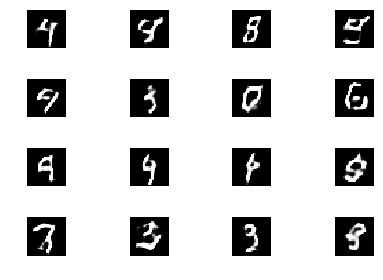

Epoch 401:
	D Network Loss: 0.689 Accuracy: 0.529
	Overall A Loss: 0.747 Accuracy: 0.367
Epoch 402:
	D Network Loss: 0.693 Accuracy: 0.549
	Overall A Loss: 0.895 Accuracy: 0.066
Epoch 403:
	D Network Loss: 0.674 Accuracy: 0.602
	Overall A Loss: 0.782 Accuracy: 0.242
Epoch 404:
	D Network Loss: 0.688 Accuracy: 0.551
	Overall A Loss: 0.960 Accuracy: 0.027
Epoch 405:
	D Network Loss: 0.660 Accuracy: 0.615
	Overall A Loss: 0.748 Accuracy: 0.316
Epoch 406:
	D Network Loss: 0.687 Accuracy: 0.561
	Overall A Loss: 0.992 Accuracy: 0.012
Epoch 407:
	D Network Loss: 0.675 Accuracy: 0.576
	Overall A Loss: 0.733 Accuracy: 0.410
Epoch 408:
	D Network Loss: 0.708 Accuracy: 0.512
	Overall A Loss: 1.080 Accuracy: 0.008
Epoch 409:
	D Network Loss: 0.677 Accuracy: 0.580
	Overall A Loss: 0.723 Accuracy: 0.418
Epoch 410:
	D Network Loss: 0.695 Accuracy: 0.533
	Overall A Loss: 1.010 Accuracy: 0.035


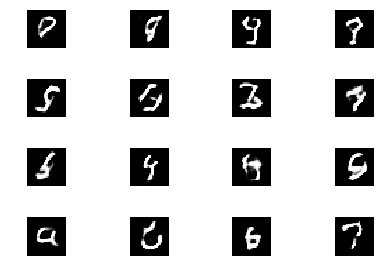

Epoch 411:
	D Network Loss: 0.672 Accuracy: 0.578
	Overall A Loss: 0.707 Accuracy: 0.465
Epoch 412:
	D Network Loss: 0.702 Accuracy: 0.518
	Overall A Loss: 1.024 Accuracy: 0.012
Epoch 413:
	D Network Loss: 0.673 Accuracy: 0.604
	Overall A Loss: 0.710 Accuracy: 0.473
Epoch 414:
	D Network Loss: 0.709 Accuracy: 0.502
	Overall A Loss: 1.032 Accuracy: 0.020
Epoch 415:
	D Network Loss: 0.681 Accuracy: 0.531
	Overall A Loss: 0.697 Accuracy: 0.496
Epoch 416:
	D Network Loss: 0.682 Accuracy: 0.539
	Overall A Loss: 0.964 Accuracy: 0.035
Epoch 417:
	D Network Loss: 0.676 Accuracy: 0.574
	Overall A Loss: 0.761 Accuracy: 0.305
Epoch 418:
	D Network Loss: 0.691 Accuracy: 0.551
	Overall A Loss: 0.927 Accuracy: 0.070
Epoch 419:
	D Network Loss: 0.678 Accuracy: 0.555
	Overall A Loss: 0.797 Accuracy: 0.238
Epoch 420:
	D Network Loss: 0.691 Accuracy: 0.527
	Overall A Loss: 0.903 Accuracy: 0.086


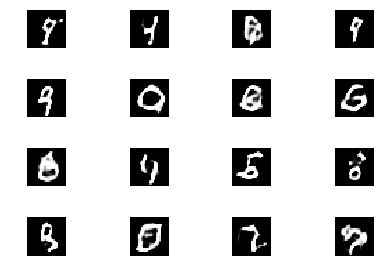

Epoch 421:
	D Network Loss: 0.684 Accuracy: 0.547
	Overall A Loss: 0.794 Accuracy: 0.234
Epoch 422:
	D Network Loss: 0.694 Accuracy: 0.531
	Overall A Loss: 1.013 Accuracy: 0.008
Epoch 423:
	D Network Loss: 0.681 Accuracy: 0.566
	Overall A Loss: 0.734 Accuracy: 0.387
Epoch 424:
	D Network Loss: 0.689 Accuracy: 0.545
	Overall A Loss: 0.934 Accuracy: 0.047
Epoch 425:
	D Network Loss: 0.672 Accuracy: 0.604
	Overall A Loss: 0.759 Accuracy: 0.312
Epoch 426:
	D Network Loss: 0.687 Accuracy: 0.527
	Overall A Loss: 0.993 Accuracy: 0.027
Epoch 427:
	D Network Loss: 0.659 Accuracy: 0.615
	Overall A Loss: 0.765 Accuracy: 0.336
Epoch 428:
	D Network Loss: 0.690 Accuracy: 0.518
	Overall A Loss: 1.058 Accuracy: 0.020
Epoch 429:
	D Network Loss: 0.671 Accuracy: 0.600
	Overall A Loss: 0.677 Accuracy: 0.559
Epoch 430:
	D Network Loss: 0.719 Accuracy: 0.529
	Overall A Loss: 1.099 Accuracy: 0.012


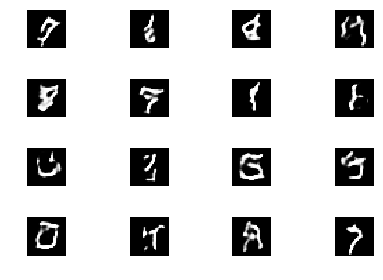

Epoch 431:
	D Network Loss: 0.675 Accuracy: 0.570
	Overall A Loss: 0.665 Accuracy: 0.594
Epoch 432:
	D Network Loss: 0.723 Accuracy: 0.512
	Overall A Loss: 1.039 Accuracy: 0.020
Epoch 433:
	D Network Loss: 0.669 Accuracy: 0.592
	Overall A Loss: 0.697 Accuracy: 0.457
Epoch 434:
	D Network Loss: 0.699 Accuracy: 0.553
	Overall A Loss: 0.960 Accuracy: 0.023
Epoch 435:
	D Network Loss: 0.673 Accuracy: 0.588
	Overall A Loss: 0.778 Accuracy: 0.266
Epoch 436:
	D Network Loss: 0.680 Accuracy: 0.553
	Overall A Loss: 0.881 Accuracy: 0.102
Epoch 437:
	D Network Loss: 0.677 Accuracy: 0.570
	Overall A Loss: 0.816 Accuracy: 0.195
Epoch 438:
	D Network Loss: 0.672 Accuracy: 0.564
	Overall A Loss: 0.923 Accuracy: 0.105
Epoch 439:
	D Network Loss: 0.676 Accuracy: 0.586
	Overall A Loss: 0.799 Accuracy: 0.230
Epoch 440:
	D Network Loss: 0.682 Accuracy: 0.543
	Overall A Loss: 0.965 Accuracy: 0.039


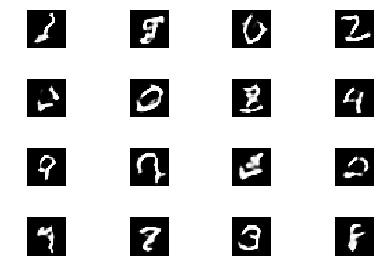

Epoch 441:
	D Network Loss: 0.669 Accuracy: 0.619
	Overall A Loss: 0.760 Accuracy: 0.379
Epoch 442:
	D Network Loss: 0.703 Accuracy: 0.516
	Overall A Loss: 1.083 Accuracy: 0.004
Epoch 443:
	D Network Loss: 0.665 Accuracy: 0.629
	Overall A Loss: 0.723 Accuracy: 0.445
Epoch 444:
	D Network Loss: 0.692 Accuracy: 0.535
	Overall A Loss: 1.114 Accuracy: 0.012
Epoch 445:
	D Network Loss: 0.681 Accuracy: 0.572
	Overall A Loss: 0.695 Accuracy: 0.492
Epoch 446:
	D Network Loss: 0.706 Accuracy: 0.525
	Overall A Loss: 0.959 Accuracy: 0.051
Epoch 447:
	D Network Loss: 0.674 Accuracy: 0.574
	Overall A Loss: 0.781 Accuracy: 0.234
Epoch 448:
	D Network Loss: 0.685 Accuracy: 0.535
	Overall A Loss: 0.961 Accuracy: 0.066
Epoch 449:
	D Network Loss: 0.659 Accuracy: 0.623
	Overall A Loss: 0.756 Accuracy: 0.324
Epoch 450:
	D Network Loss: 0.681 Accuracy: 0.564
	Overall A Loss: 0.985 Accuracy: 0.070


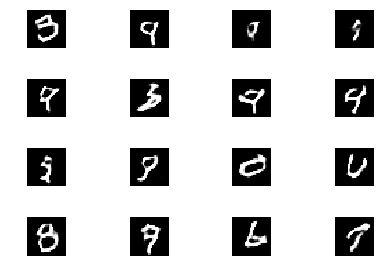

Epoch 451:
	D Network Loss: 0.672 Accuracy: 0.602
	Overall A Loss: 0.772 Accuracy: 0.320
Epoch 452:
	D Network Loss: 0.687 Accuracy: 0.545
	Overall A Loss: 0.984 Accuracy: 0.039
Epoch 453:
	D Network Loss: 0.681 Accuracy: 0.512
	Overall A Loss: 0.815 Accuracy: 0.258
Epoch 454:
	D Network Loss: 0.673 Accuracy: 0.568
	Overall A Loss: 1.021 Accuracy: 0.035
Epoch 455:
	D Network Loss: 0.675 Accuracy: 0.582
	Overall A Loss: 0.704 Accuracy: 0.508
Epoch 456:
	D Network Loss: 0.697 Accuracy: 0.539
	Overall A Loss: 1.127 Accuracy: 0.012
Epoch 457:
	D Network Loss: 0.676 Accuracy: 0.572
	Overall A Loss: 0.635 Accuracy: 0.664
Epoch 458:
	D Network Loss: 0.727 Accuracy: 0.525
	Overall A Loss: 1.027 Accuracy: 0.023
Epoch 459:
	D Network Loss: 0.682 Accuracy: 0.555
	Overall A Loss: 0.732 Accuracy: 0.461
Epoch 460:
	D Network Loss: 0.701 Accuracy: 0.518
	Overall A Loss: 0.944 Accuracy: 0.086


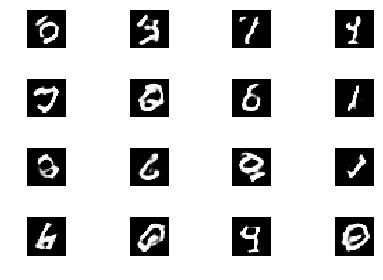

Epoch 461:
	D Network Loss: 0.666 Accuracy: 0.572
	Overall A Loss: 0.784 Accuracy: 0.285
Epoch 462:
	D Network Loss: 0.687 Accuracy: 0.541
	Overall A Loss: 0.927 Accuracy: 0.078
Epoch 463:
	D Network Loss: 0.664 Accuracy: 0.631
	Overall A Loss: 0.771 Accuracy: 0.289
Epoch 464:
	D Network Loss: 0.696 Accuracy: 0.531
	Overall A Loss: 0.950 Accuracy: 0.051
Epoch 465:
	D Network Loss: 0.672 Accuracy: 0.596
	Overall A Loss: 0.742 Accuracy: 0.379
Epoch 466:
	D Network Loss: 0.687 Accuracy: 0.533
	Overall A Loss: 1.011 Accuracy: 0.027
Epoch 467:
	D Network Loss: 0.668 Accuracy: 0.582
	Overall A Loss: 0.760 Accuracy: 0.289
Epoch 468:
	D Network Loss: 0.696 Accuracy: 0.531
	Overall A Loss: 1.039 Accuracy: 0.023
Epoch 469:
	D Network Loss: 0.675 Accuracy: 0.574
	Overall A Loss: 0.772 Accuracy: 0.320
Epoch 470:
	D Network Loss: 0.692 Accuracy: 0.520
	Overall A Loss: 0.953 Accuracy: 0.062


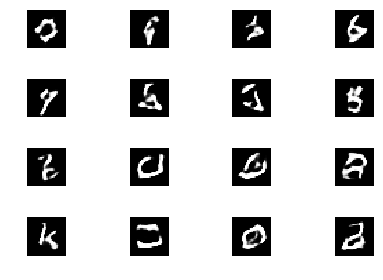

Epoch 471:
	D Network Loss: 0.665 Accuracy: 0.613
	Overall A Loss: 0.786 Accuracy: 0.266
Epoch 472:
	D Network Loss: 0.667 Accuracy: 0.604
	Overall A Loss: 0.919 Accuracy: 0.094
Epoch 473:
	D Network Loss: 0.666 Accuracy: 0.600
	Overall A Loss: 0.841 Accuracy: 0.164
Epoch 474:
	D Network Loss: 0.669 Accuracy: 0.592
	Overall A Loss: 0.936 Accuracy: 0.062
Epoch 475:
	D Network Loss: 0.672 Accuracy: 0.574
	Overall A Loss: 0.819 Accuracy: 0.250
Epoch 476:
	D Network Loss: 0.681 Accuracy: 0.559
	Overall A Loss: 1.017 Accuracy: 0.047
Epoch 477:
	D Network Loss: 0.669 Accuracy: 0.611
	Overall A Loss: 0.820 Accuracy: 0.238
Epoch 478:
	D Network Loss: 0.677 Accuracy: 0.557
	Overall A Loss: 1.173 Accuracy: 0.016
Epoch 479:
	D Network Loss: 0.681 Accuracy: 0.568
	Overall A Loss: 0.647 Accuracy: 0.664
Epoch 480:
	D Network Loss: 0.718 Accuracy: 0.504
	Overall A Loss: 1.172 Accuracy: 0.004


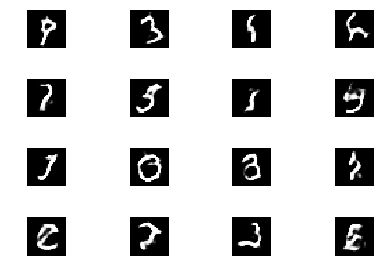

Epoch 481:
	D Network Loss: 0.684 Accuracy: 0.570
	Overall A Loss: 0.672 Accuracy: 0.570
Epoch 482:
	D Network Loss: 0.711 Accuracy: 0.516
	Overall A Loss: 0.964 Accuracy: 0.039
Epoch 483:
	D Network Loss: 0.675 Accuracy: 0.574
	Overall A Loss: 0.734 Accuracy: 0.371
Epoch 484:
	D Network Loss: 0.704 Accuracy: 0.541
	Overall A Loss: 0.932 Accuracy: 0.055
Epoch 485:
	D Network Loss: 0.677 Accuracy: 0.596
	Overall A Loss: 0.796 Accuracy: 0.273
Epoch 486:
	D Network Loss: 0.677 Accuracy: 0.539
	Overall A Loss: 0.890 Accuracy: 0.109
Epoch 487:
	D Network Loss: 0.668 Accuracy: 0.592
	Overall A Loss: 0.849 Accuracy: 0.191
Epoch 488:
	D Network Loss: 0.675 Accuracy: 0.576
	Overall A Loss: 0.887 Accuracy: 0.156
Epoch 489:
	D Network Loss: 0.665 Accuracy: 0.605
	Overall A Loss: 0.887 Accuracy: 0.129
Epoch 490:
	D Network Loss: 0.681 Accuracy: 0.561
	Overall A Loss: 0.935 Accuracy: 0.086


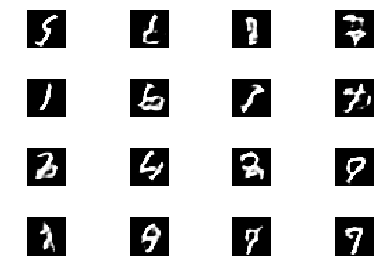

Epoch 491:
	D Network Loss: 0.678 Accuracy: 0.568
	Overall A Loss: 0.855 Accuracy: 0.188
Epoch 492:
	D Network Loss: 0.682 Accuracy: 0.555
	Overall A Loss: 0.956 Accuracy: 0.090
Epoch 493:
	D Network Loss: 0.662 Accuracy: 0.596
	Overall A Loss: 0.911 Accuracy: 0.105
Epoch 494:
	D Network Loss: 0.688 Accuracy: 0.559
	Overall A Loss: 0.972 Accuracy: 0.059
Epoch 495:
	D Network Loss: 0.660 Accuracy: 0.592
	Overall A Loss: 0.764 Accuracy: 0.375
Epoch 496:
	D Network Loss: 0.680 Accuracy: 0.576
	Overall A Loss: 1.136 Accuracy: 0.008
Epoch 497:
	D Network Loss: 0.678 Accuracy: 0.566
	Overall A Loss: 0.659 Accuracy: 0.590
Epoch 498:
	D Network Loss: 0.725 Accuracy: 0.498
	Overall A Loss: 1.203 Accuracy: 0.012
Epoch 499:
	D Network Loss: 0.690 Accuracy: 0.543
	Overall A Loss: 0.666 Accuracy: 0.586
Epoch 500:
	D Network Loss: 0.710 Accuracy: 0.523
	Overall A Loss: 1.062 Accuracy: 0.020


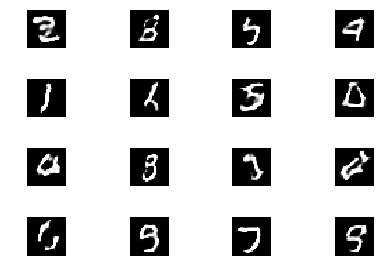

Epoch 501:
	D Network Loss: 0.683 Accuracy: 0.564
	Overall A Loss: 0.725 Accuracy: 0.453
Epoch 502:
	D Network Loss: 0.695 Accuracy: 0.537
	Overall A Loss: 0.910 Accuracy: 0.055
Epoch 503:
	D Network Loss: 0.667 Accuracy: 0.602
	Overall A Loss: 0.782 Accuracy: 0.297
Epoch 504:
	D Network Loss: 0.683 Accuracy: 0.543
	Overall A Loss: 0.908 Accuracy: 0.078
Epoch 505:
	D Network Loss: 0.683 Accuracy: 0.561
	Overall A Loss: 0.843 Accuracy: 0.176
Epoch 506:
	D Network Loss: 0.670 Accuracy: 0.598
	Overall A Loss: 0.813 Accuracy: 0.262
Epoch 507:
	D Network Loss: 0.675 Accuracy: 0.566
	Overall A Loss: 0.947 Accuracy: 0.098
Epoch 508:
	D Network Loss: 0.659 Accuracy: 0.590
	Overall A Loss: 0.806 Accuracy: 0.289
Epoch 509:
	D Network Loss: 0.690 Accuracy: 0.547
	Overall A Loss: 0.953 Accuracy: 0.082
Epoch 510:
	D Network Loss: 0.666 Accuracy: 0.619
	Overall A Loss: 0.805 Accuracy: 0.250


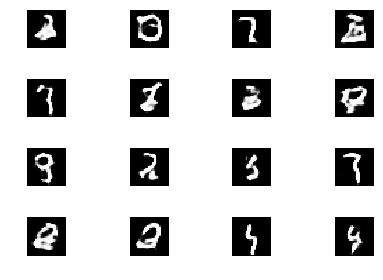

Epoch 511:
	D Network Loss: 0.707 Accuracy: 0.529
	Overall A Loss: 1.058 Accuracy: 0.023
Epoch 512:
	D Network Loss: 0.676 Accuracy: 0.604
	Overall A Loss: 0.682 Accuracy: 0.543
Epoch 513:
	D Network Loss: 0.704 Accuracy: 0.520
	Overall A Loss: 1.104 Accuracy: 0.031
Epoch 514:
	D Network Loss: 0.694 Accuracy: 0.539
	Overall A Loss: 0.680 Accuracy: 0.543
Epoch 515:
	D Network Loss: 0.706 Accuracy: 0.514
	Overall A Loss: 0.992 Accuracy: 0.047
Epoch 516:
	D Network Loss: 0.677 Accuracy: 0.586
	Overall A Loss: 0.735 Accuracy: 0.402
Epoch 517:
	D Network Loss: 0.697 Accuracy: 0.527
	Overall A Loss: 0.974 Accuracy: 0.055
Epoch 518:
	D Network Loss: 0.670 Accuracy: 0.602
	Overall A Loss: 0.753 Accuracy: 0.324
Epoch 519:
	D Network Loss: 0.686 Accuracy: 0.551
	Overall A Loss: 0.930 Accuracy: 0.098
Epoch 520:
	D Network Loss: 0.666 Accuracy: 0.604
	Overall A Loss: 0.771 Accuracy: 0.320


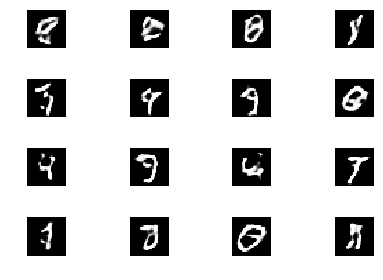

Epoch 521:
	D Network Loss: 0.683 Accuracy: 0.541
	Overall A Loss: 0.964 Accuracy: 0.047
Epoch 522:
	D Network Loss: 0.686 Accuracy: 0.531
	Overall A Loss: 0.775 Accuracy: 0.340
Epoch 523:
	D Network Loss: 0.701 Accuracy: 0.543
	Overall A Loss: 0.953 Accuracy: 0.059
Epoch 524:
	D Network Loss: 0.673 Accuracy: 0.602
	Overall A Loss: 0.753 Accuracy: 0.363
Epoch 525:
	D Network Loss: 0.683 Accuracy: 0.568
	Overall A Loss: 0.933 Accuracy: 0.086
Epoch 526:
	D Network Loss: 0.668 Accuracy: 0.584
	Overall A Loss: 0.814 Accuracy: 0.246
Epoch 527:
	D Network Loss: 0.687 Accuracy: 0.551
	Overall A Loss: 0.992 Accuracy: 0.047
Epoch 528:
	D Network Loss: 0.688 Accuracy: 0.529
	Overall A Loss: 0.785 Accuracy: 0.289
Epoch 529:
	D Network Loss: 0.694 Accuracy: 0.562
	Overall A Loss: 1.047 Accuracy: 0.039
Epoch 530:
	D Network Loss: 0.672 Accuracy: 0.576
	Overall A Loss: 0.674 Accuracy: 0.590


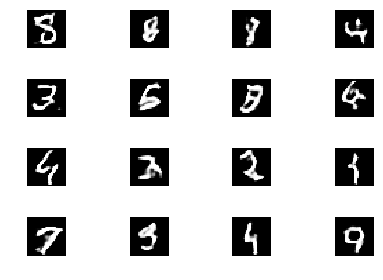

Epoch 531:
	D Network Loss: 0.705 Accuracy: 0.518
	Overall A Loss: 1.082 Accuracy: 0.008
Epoch 532:
	D Network Loss: 0.685 Accuracy: 0.557
	Overall A Loss: 0.692 Accuracy: 0.539
Epoch 533:
	D Network Loss: 0.698 Accuracy: 0.521
	Overall A Loss: 0.987 Accuracy: 0.078
Epoch 534:
	D Network Loss: 0.674 Accuracy: 0.576
	Overall A Loss: 0.791 Accuracy: 0.258
Epoch 535:
	D Network Loss: 0.685 Accuracy: 0.531
	Overall A Loss: 0.938 Accuracy: 0.105
Epoch 536:
	D Network Loss: 0.659 Accuracy: 0.582
	Overall A Loss: 0.775 Accuracy: 0.309
Epoch 537:
	D Network Loss: 0.691 Accuracy: 0.545
	Overall A Loss: 0.942 Accuracy: 0.070
Epoch 538:
	D Network Loss: 0.683 Accuracy: 0.555
	Overall A Loss: 0.801 Accuracy: 0.281
Epoch 539:
	D Network Loss: 0.684 Accuracy: 0.566
	Overall A Loss: 0.945 Accuracy: 0.074
Epoch 540:
	D Network Loss: 0.669 Accuracy: 0.613
	Overall A Loss: 0.806 Accuracy: 0.254


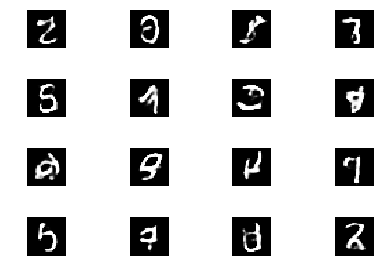

Epoch 541:
	D Network Loss: 0.702 Accuracy: 0.537
	Overall A Loss: 0.980 Accuracy: 0.070
Epoch 542:
	D Network Loss: 0.674 Accuracy: 0.580
	Overall A Loss: 0.705 Accuracy: 0.520
Epoch 543:
	D Network Loss: 0.696 Accuracy: 0.539
	Overall A Loss: 1.019 Accuracy: 0.047
Epoch 544:
	D Network Loss: 0.673 Accuracy: 0.576
	Overall A Loss: 0.754 Accuracy: 0.344
Epoch 545:
	D Network Loss: 0.708 Accuracy: 0.486
	Overall A Loss: 1.025 Accuracy: 0.027
Epoch 546:
	D Network Loss: 0.679 Accuracy: 0.570
	Overall A Loss: 0.731 Accuracy: 0.430
Epoch 547:
	D Network Loss: 0.695 Accuracy: 0.525
	Overall A Loss: 0.994 Accuracy: 0.043
Epoch 548:
	D Network Loss: 0.678 Accuracy: 0.568
	Overall A Loss: 0.761 Accuracy: 0.352
Epoch 549:
	D Network Loss: 0.700 Accuracy: 0.510
	Overall A Loss: 0.974 Accuracy: 0.059
Epoch 550:
	D Network Loss: 0.674 Accuracy: 0.604
	Overall A Loss: 0.745 Accuracy: 0.406


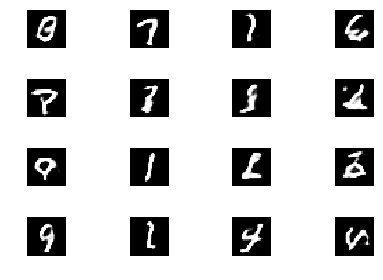

Epoch 551:
	D Network Loss: 0.697 Accuracy: 0.535
	Overall A Loss: 1.016 Accuracy: 0.004
Epoch 552:
	D Network Loss: 0.672 Accuracy: 0.572
	Overall A Loss: 0.769 Accuracy: 0.324
Epoch 553:
	D Network Loss: 0.697 Accuracy: 0.521
	Overall A Loss: 0.923 Accuracy: 0.098
Epoch 554:
	D Network Loss: 0.661 Accuracy: 0.625
	Overall A Loss: 0.782 Accuracy: 0.305
Epoch 555:
	D Network Loss: 0.672 Accuracy: 0.559
	Overall A Loss: 0.894 Accuracy: 0.121
Epoch 556:
	D Network Loss: 0.672 Accuracy: 0.582
	Overall A Loss: 0.845 Accuracy: 0.207
Epoch 557:
	D Network Loss: 0.685 Accuracy: 0.564
	Overall A Loss: 0.900 Accuracy: 0.117
Epoch 558:
	D Network Loss: 0.682 Accuracy: 0.568
	Overall A Loss: 0.873 Accuracy: 0.148
Epoch 559:
	D Network Loss: 0.677 Accuracy: 0.572
	Overall A Loss: 0.906 Accuracy: 0.137
Epoch 560:
	D Network Loss: 0.672 Accuracy: 0.592
	Overall A Loss: 0.905 Accuracy: 0.117


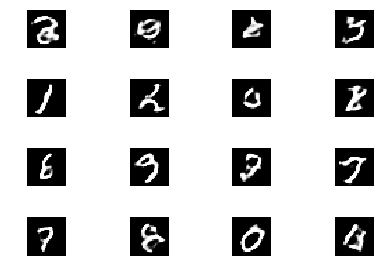

Epoch 561:
	D Network Loss: 0.661 Accuracy: 0.600
	Overall A Loss: 0.924 Accuracy: 0.109
Epoch 562:
	D Network Loss: 0.669 Accuracy: 0.592
	Overall A Loss: 0.946 Accuracy: 0.090
Epoch 563:
	D Network Loss: 0.666 Accuracy: 0.598
	Overall A Loss: 0.875 Accuracy: 0.156
Epoch 564:
	D Network Loss: 0.685 Accuracy: 0.553
	Overall A Loss: 1.094 Accuracy: 0.027
Epoch 565:
	D Network Loss: 0.668 Accuracy: 0.574
	Overall A Loss: 0.755 Accuracy: 0.332
Epoch 566:
	D Network Loss: 0.705 Accuracy: 0.533
	Overall A Loss: 1.231 Accuracy: 0.004
Epoch 567:
	D Network Loss: 0.689 Accuracy: 0.557
	Overall A Loss: 0.578 Accuracy: 0.781
Epoch 568:
	D Network Loss: 0.758 Accuracy: 0.498
	Overall A Loss: 1.139 Accuracy: 0.020
Epoch 569:
	D Network Loss: 0.684 Accuracy: 0.555
	Overall A Loss: 0.689 Accuracy: 0.539
Epoch 570:
	D Network Loss: 0.682 Accuracy: 0.559
	Overall A Loss: 0.872 Accuracy: 0.152


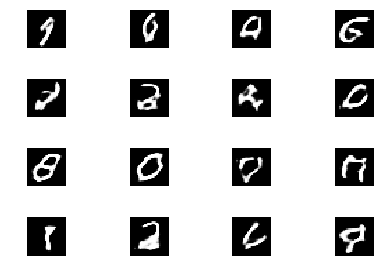

Epoch 571:
	D Network Loss: 0.679 Accuracy: 0.574
	Overall A Loss: 0.839 Accuracy: 0.199
Epoch 572:
	D Network Loss: 0.680 Accuracy: 0.539
	Overall A Loss: 0.844 Accuracy: 0.180
Epoch 573:
	D Network Loss: 0.681 Accuracy: 0.553
	Overall A Loss: 0.817 Accuracy: 0.230
Epoch 574:
	D Network Loss: 0.685 Accuracy: 0.582
	Overall A Loss: 0.892 Accuracy: 0.121
Epoch 575:
	D Network Loss: 0.672 Accuracy: 0.592
	Overall A Loss: 0.817 Accuracy: 0.254
Epoch 576:
	D Network Loss: 0.672 Accuracy: 0.598
	Overall A Loss: 0.892 Accuracy: 0.113
Epoch 577:
	D Network Loss: 0.662 Accuracy: 0.604
	Overall A Loss: 0.864 Accuracy: 0.156
Epoch 578:
	D Network Loss: 0.681 Accuracy: 0.545
	Overall A Loss: 0.907 Accuracy: 0.129
Epoch 579:
	D Network Loss: 0.691 Accuracy: 0.545
	Overall A Loss: 0.938 Accuracy: 0.113
Epoch 580:
	D Network Loss: 0.664 Accuracy: 0.615
	Overall A Loss: 0.816 Accuracy: 0.254


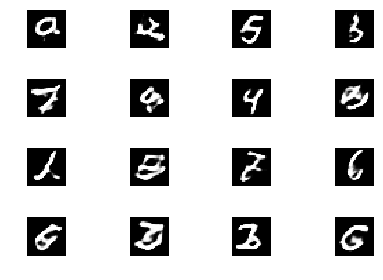

Epoch 581:
	D Network Loss: 0.694 Accuracy: 0.539
	Overall A Loss: 1.028 Accuracy: 0.047
Epoch 582:
	D Network Loss: 0.669 Accuracy: 0.574
	Overall A Loss: 0.786 Accuracy: 0.336
Epoch 583:
	D Network Loss: 0.698 Accuracy: 0.535
	Overall A Loss: 1.083 Accuracy: 0.031
Epoch 584:
	D Network Loss: 0.656 Accuracy: 0.605
	Overall A Loss: 0.659 Accuracy: 0.605
Epoch 585:
	D Network Loss: 0.721 Accuracy: 0.512
	Overall A Loss: 1.129 Accuracy: 0.008
Epoch 586:
	D Network Loss: 0.689 Accuracy: 0.551
	Overall A Loss: 0.674 Accuracy: 0.543
Epoch 587:
	D Network Loss: 0.708 Accuracy: 0.506
	Overall A Loss: 1.046 Accuracy: 0.027
Epoch 588:
	D Network Loss: 0.669 Accuracy: 0.592
	Overall A Loss: 0.743 Accuracy: 0.391
Epoch 589:
	D Network Loss: 0.681 Accuracy: 0.553
	Overall A Loss: 0.975 Accuracy: 0.059
Epoch 590:
	D Network Loss: 0.670 Accuracy: 0.592
	Overall A Loss: 0.776 Accuracy: 0.316


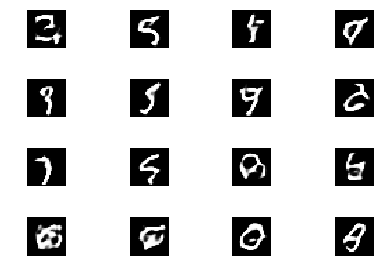

Epoch 591:
	D Network Loss: 0.698 Accuracy: 0.527
	Overall A Loss: 0.996 Accuracy: 0.059
Epoch 592:
	D Network Loss: 0.667 Accuracy: 0.588
	Overall A Loss: 0.773 Accuracy: 0.320
Epoch 593:
	D Network Loss: 0.698 Accuracy: 0.525
	Overall A Loss: 0.961 Accuracy: 0.074
Epoch 594:
	D Network Loss: 0.675 Accuracy: 0.584
	Overall A Loss: 0.776 Accuracy: 0.301
Epoch 595:
	D Network Loss: 0.689 Accuracy: 0.535
	Overall A Loss: 0.947 Accuracy: 0.078
Epoch 596:
	D Network Loss: 0.672 Accuracy: 0.596
	Overall A Loss: 0.754 Accuracy: 0.348
Epoch 597:
	D Network Loss: 0.698 Accuracy: 0.523
	Overall A Loss: 1.022 Accuracy: 0.027
Epoch 598:
	D Network Loss: 0.672 Accuracy: 0.584
	Overall A Loss: 0.773 Accuracy: 0.309
Epoch 599:
	D Network Loss: 0.698 Accuracy: 0.525
	Overall A Loss: 0.959 Accuracy: 0.062
Epoch 600:
	D Network Loss: 0.666 Accuracy: 0.596
	Overall A Loss: 0.784 Accuracy: 0.297


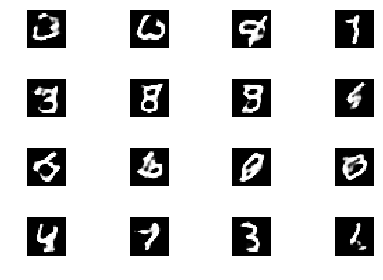

Epoch 601:
	D Network Loss: 0.689 Accuracy: 0.527
	Overall A Loss: 1.005 Accuracy: 0.051
Epoch 602:
	D Network Loss: 0.676 Accuracy: 0.576
	Overall A Loss: 0.744 Accuracy: 0.426
Epoch 603:
	D Network Loss: 0.687 Accuracy: 0.574
	Overall A Loss: 1.017 Accuracy: 0.043
Epoch 604:
	D Network Loss: 0.669 Accuracy: 0.596
	Overall A Loss: 0.723 Accuracy: 0.445
Epoch 605:
	D Network Loss: 0.708 Accuracy: 0.520
	Overall A Loss: 1.084 Accuracy: 0.043
Epoch 606:
	D Network Loss: 0.676 Accuracy: 0.561
	Overall A Loss: 0.714 Accuracy: 0.488
Epoch 607:
	D Network Loss: 0.709 Accuracy: 0.533
	Overall A Loss: 1.029 Accuracy: 0.023
Epoch 608:
	D Network Loss: 0.673 Accuracy: 0.584
	Overall A Loss: 0.738 Accuracy: 0.391
Epoch 609:
	D Network Loss: 0.683 Accuracy: 0.551
	Overall A Loss: 0.965 Accuracy: 0.078
Epoch 610:
	D Network Loss: 0.670 Accuracy: 0.586
	Overall A Loss: 0.769 Accuracy: 0.332


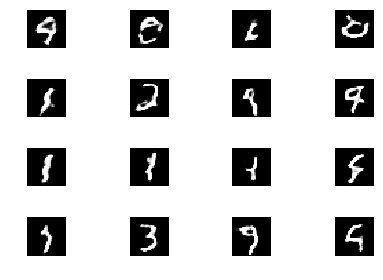

Epoch 611:
	D Network Loss: 0.693 Accuracy: 0.576
	Overall A Loss: 0.961 Accuracy: 0.078
Epoch 612:
	D Network Loss: 0.676 Accuracy: 0.580
	Overall A Loss: 0.772 Accuracy: 0.344
Epoch 613:
	D Network Loss: 0.672 Accuracy: 0.551
	Overall A Loss: 0.960 Accuracy: 0.098
Epoch 614:
	D Network Loss: 0.690 Accuracy: 0.543
	Overall A Loss: 0.821 Accuracy: 0.234
Epoch 615:
	D Network Loss: 0.683 Accuracy: 0.566
	Overall A Loss: 0.959 Accuracy: 0.098
Epoch 616:
	D Network Loss: 0.673 Accuracy: 0.574
	Overall A Loss: 0.851 Accuracy: 0.207
Epoch 617:
	D Network Loss: 0.677 Accuracy: 0.559
	Overall A Loss: 1.015 Accuracy: 0.055
Epoch 618:
	D Network Loss: 0.672 Accuracy: 0.561
	Overall A Loss: 0.790 Accuracy: 0.320
Epoch 619:
	D Network Loss: 0.676 Accuracy: 0.584
	Overall A Loss: 1.051 Accuracy: 0.051
Epoch 620:
	D Network Loss: 0.659 Accuracy: 0.596
	Overall A Loss: 0.719 Accuracy: 0.484


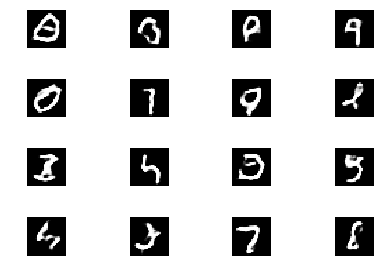

Epoch 621:
	D Network Loss: 0.720 Accuracy: 0.521
	Overall A Loss: 1.148 Accuracy: 0.016
Epoch 622:
	D Network Loss: 0.699 Accuracy: 0.531
	Overall A Loss: 0.680 Accuracy: 0.535
Epoch 623:
	D Network Loss: 0.705 Accuracy: 0.529
	Overall A Loss: 0.973 Accuracy: 0.062
Epoch 624:
	D Network Loss: 0.663 Accuracy: 0.590
	Overall A Loss: 0.803 Accuracy: 0.289
Epoch 625:
	D Network Loss: 0.699 Accuracy: 0.529
	Overall A Loss: 0.917 Accuracy: 0.105
Epoch 626:
	D Network Loss: 0.667 Accuracy: 0.600
	Overall A Loss: 0.817 Accuracy: 0.250
Epoch 627:
	D Network Loss: 0.682 Accuracy: 0.551
	Overall A Loss: 0.927 Accuracy: 0.105
Epoch 628:
	D Network Loss: 0.686 Accuracy: 0.562
	Overall A Loss: 0.820 Accuracy: 0.250
Epoch 629:
	D Network Loss: 0.674 Accuracy: 0.566
	Overall A Loss: 0.908 Accuracy: 0.133
Epoch 630:
	D Network Loss: 0.665 Accuracy: 0.568
	Overall A Loss: 0.843 Accuracy: 0.195


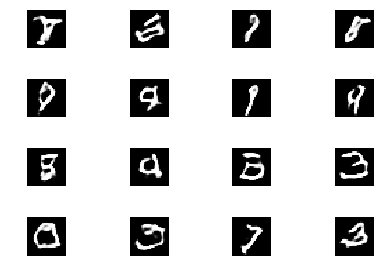

Epoch 631:
	D Network Loss: 0.676 Accuracy: 0.555
	Overall A Loss: 0.947 Accuracy: 0.113
Epoch 632:
	D Network Loss: 0.672 Accuracy: 0.590
	Overall A Loss: 0.821 Accuracy: 0.254
Epoch 633:
	D Network Loss: 0.688 Accuracy: 0.559
	Overall A Loss: 1.047 Accuracy: 0.035
Epoch 634:
	D Network Loss: 0.684 Accuracy: 0.562
	Overall A Loss: 0.770 Accuracy: 0.336
Epoch 635:
	D Network Loss: 0.689 Accuracy: 0.537
	Overall A Loss: 0.992 Accuracy: 0.051
Epoch 636:
	D Network Loss: 0.663 Accuracy: 0.625
	Overall A Loss: 0.773 Accuracy: 0.344
Epoch 637:
	D Network Loss: 0.697 Accuracy: 0.514
	Overall A Loss: 1.136 Accuracy: 0.020
Epoch 638:
	D Network Loss: 0.663 Accuracy: 0.600
	Overall A Loss: 0.675 Accuracy: 0.535
Epoch 639:
	D Network Loss: 0.713 Accuracy: 0.518
	Overall A Loss: 1.095 Accuracy: 0.016
Epoch 640:
	D Network Loss: 0.677 Accuracy: 0.557
	Overall A Loss: 0.685 Accuracy: 0.531


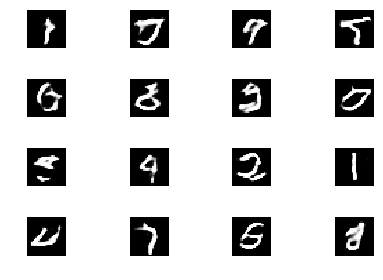

Epoch 641:
	D Network Loss: 0.707 Accuracy: 0.529
	Overall A Loss: 0.950 Accuracy: 0.082
Epoch 642:
	D Network Loss: 0.666 Accuracy: 0.568
	Overall A Loss: 0.779 Accuracy: 0.309
Epoch 643:
	D Network Loss: 0.681 Accuracy: 0.561
	Overall A Loss: 0.922 Accuracy: 0.141
Epoch 644:
	D Network Loss: 0.662 Accuracy: 0.615
	Overall A Loss: 0.779 Accuracy: 0.316
Epoch 645:
	D Network Loss: 0.690 Accuracy: 0.551
	Overall A Loss: 0.961 Accuracy: 0.062
Epoch 646:
	D Network Loss: 0.681 Accuracy: 0.557
	Overall A Loss: 0.833 Accuracy: 0.242
Epoch 647:
	D Network Loss: 0.676 Accuracy: 0.588
	Overall A Loss: 0.935 Accuracy: 0.109
Epoch 648:
	D Network Loss: 0.663 Accuracy: 0.613
	Overall A Loss: 0.861 Accuracy: 0.160
Epoch 649:
	D Network Loss: 0.683 Accuracy: 0.555
	Overall A Loss: 0.940 Accuracy: 0.121
Epoch 650:
	D Network Loss: 0.669 Accuracy: 0.602
	Overall A Loss: 0.788 Accuracy: 0.320


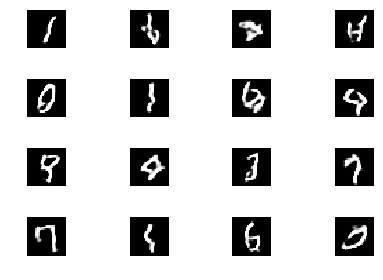

Epoch 651:
	D Network Loss: 0.668 Accuracy: 0.590
	Overall A Loss: 0.992 Accuracy: 0.059
Epoch 652:
	D Network Loss: 0.679 Accuracy: 0.557
	Overall A Loss: 0.769 Accuracy: 0.355
Epoch 653:
	D Network Loss: 0.690 Accuracy: 0.539
	Overall A Loss: 1.075 Accuracy: 0.047
Epoch 654:
	D Network Loss: 0.657 Accuracy: 0.596
	Overall A Loss: 0.731 Accuracy: 0.426
Epoch 655:
	D Network Loss: 0.719 Accuracy: 0.518
	Overall A Loss: 1.140 Accuracy: 0.027
Epoch 656:
	D Network Loss: 0.694 Accuracy: 0.533
	Overall A Loss: 0.691 Accuracy: 0.492
Epoch 657:
	D Network Loss: 0.707 Accuracy: 0.531
	Overall A Loss: 0.978 Accuracy: 0.051
Epoch 658:
	D Network Loss: 0.675 Accuracy: 0.596
	Overall A Loss: 0.795 Accuracy: 0.305
Epoch 659:
	D Network Loss: 0.677 Accuracy: 0.549
	Overall A Loss: 0.905 Accuracy: 0.105
Epoch 660:
	D Network Loss: 0.667 Accuracy: 0.600
	Overall A Loss: 0.815 Accuracy: 0.273


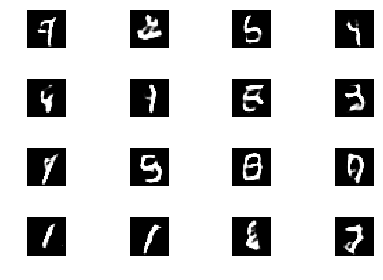

Epoch 661:
	D Network Loss: 0.709 Accuracy: 0.516
	Overall A Loss: 0.987 Accuracy: 0.078
Epoch 662:
	D Network Loss: 0.678 Accuracy: 0.553
	Overall A Loss: 0.778 Accuracy: 0.332
Epoch 663:
	D Network Loss: 0.696 Accuracy: 0.549
	Overall A Loss: 0.965 Accuracy: 0.066
Epoch 664:
	D Network Loss: 0.668 Accuracy: 0.572
	Overall A Loss: 0.806 Accuracy: 0.254
Epoch 665:
	D Network Loss: 0.696 Accuracy: 0.533
	Overall A Loss: 0.986 Accuracy: 0.051
Epoch 666:
	D Network Loss: 0.681 Accuracy: 0.555
	Overall A Loss: 0.749 Accuracy: 0.414
Epoch 667:
	D Network Loss: 0.684 Accuracy: 0.572
	Overall A Loss: 0.928 Accuracy: 0.090
Epoch 668:
	D Network Loss: 0.665 Accuracy: 0.607
	Overall A Loss: 0.781 Accuracy: 0.324
Epoch 669:
	D Network Loss: 0.690 Accuracy: 0.543
	Overall A Loss: 1.040 Accuracy: 0.051
Epoch 670:
	D Network Loss: 0.667 Accuracy: 0.600
	Overall A Loss: 0.736 Accuracy: 0.469


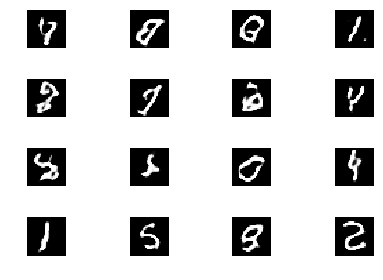

Epoch 671:
	D Network Loss: 0.697 Accuracy: 0.549
	Overall A Loss: 1.025 Accuracy: 0.039
Epoch 672:
	D Network Loss: 0.678 Accuracy: 0.553
	Overall A Loss: 0.710 Accuracy: 0.473
Epoch 673:
	D Network Loss: 0.681 Accuracy: 0.547
	Overall A Loss: 1.007 Accuracy: 0.059
Epoch 674:
	D Network Loss: 0.682 Accuracy: 0.549
	Overall A Loss: 0.740 Accuracy: 0.395
Epoch 675:
	D Network Loss: 0.698 Accuracy: 0.531
	Overall A Loss: 0.920 Accuracy: 0.113
Epoch 676:
	D Network Loss: 0.677 Accuracy: 0.582
	Overall A Loss: 0.814 Accuracy: 0.242
Epoch 677:
	D Network Loss: 0.674 Accuracy: 0.580
	Overall A Loss: 0.891 Accuracy: 0.129
Epoch 678:
	D Network Loss: 0.657 Accuracy: 0.621
	Overall A Loss: 0.789 Accuracy: 0.316
Epoch 679:
	D Network Loss: 0.678 Accuracy: 0.549
	Overall A Loss: 0.947 Accuracy: 0.137
Epoch 680:
	D Network Loss: 0.681 Accuracy: 0.584
	Overall A Loss: 0.803 Accuracy: 0.266


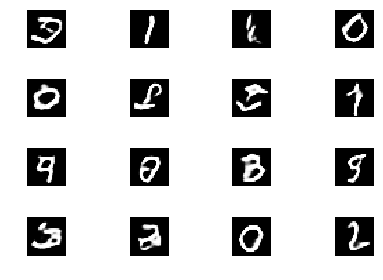

Epoch 681:
	D Network Loss: 0.692 Accuracy: 0.561
	Overall A Loss: 1.017 Accuracy: 0.039
Epoch 682:
	D Network Loss: 0.686 Accuracy: 0.547
	Overall A Loss: 0.727 Accuracy: 0.441
Epoch 683:
	D Network Loss: 0.683 Accuracy: 0.539
	Overall A Loss: 1.026 Accuracy: 0.086
Epoch 684:
	D Network Loss: 0.677 Accuracy: 0.561
	Overall A Loss: 0.741 Accuracy: 0.383
Epoch 685:
	D Network Loss: 0.696 Accuracy: 0.545
	Overall A Loss: 1.017 Accuracy: 0.035
Epoch 686:
	D Network Loss: 0.672 Accuracy: 0.598
	Overall A Loss: 0.802 Accuracy: 0.293
Epoch 687:
	D Network Loss: 0.697 Accuracy: 0.518
	Overall A Loss: 0.931 Accuracy: 0.082
Epoch 688:
	D Network Loss: 0.685 Accuracy: 0.574
	Overall A Loss: 0.811 Accuracy: 0.262
Epoch 689:
	D Network Loss: 0.697 Accuracy: 0.529
	Overall A Loss: 0.951 Accuracy: 0.066
Epoch 690:
	D Network Loss: 0.674 Accuracy: 0.584
	Overall A Loss: 0.782 Accuracy: 0.320


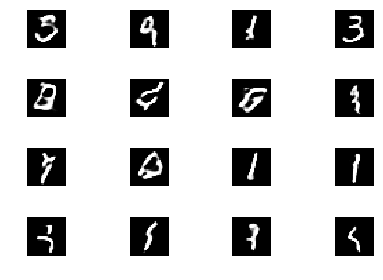

Epoch 691:
	D Network Loss: 0.692 Accuracy: 0.521
	Overall A Loss: 0.975 Accuracy: 0.070
Epoch 692:
	D Network Loss: 0.656 Accuracy: 0.609
	Overall A Loss: 0.817 Accuracy: 0.238
Epoch 693:
	D Network Loss: 0.715 Accuracy: 0.516
	Overall A Loss: 1.017 Accuracy: 0.051
Epoch 694:
	D Network Loss: 0.668 Accuracy: 0.609
	Overall A Loss: 0.736 Accuracy: 0.410
Epoch 695:
	D Network Loss: 0.705 Accuracy: 0.533
	Overall A Loss: 0.993 Accuracy: 0.066
Epoch 696:
	D Network Loss: 0.666 Accuracy: 0.576
	Overall A Loss: 0.732 Accuracy: 0.441
Epoch 697:
	D Network Loss: 0.693 Accuracy: 0.531
	Overall A Loss: 1.040 Accuracy: 0.027
Epoch 698:
	D Network Loss: 0.662 Accuracy: 0.600
	Overall A Loss: 0.753 Accuracy: 0.344
Epoch 699:
	D Network Loss: 0.693 Accuracy: 0.541
	Overall A Loss: 0.996 Accuracy: 0.051
Epoch 700:
	D Network Loss: 0.676 Accuracy: 0.566
	Overall A Loss: 0.743 Accuracy: 0.379


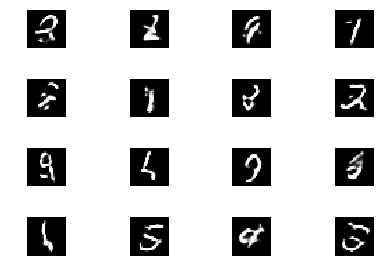

Epoch 701:
	D Network Loss: 0.695 Accuracy: 0.566
	Overall A Loss: 0.974 Accuracy: 0.066
Epoch 702:
	D Network Loss: 0.660 Accuracy: 0.604
	Overall A Loss: 0.784 Accuracy: 0.340
Epoch 703:
	D Network Loss: 0.689 Accuracy: 0.529
	Overall A Loss: 0.997 Accuracy: 0.062
Epoch 704:
	D Network Loss: 0.674 Accuracy: 0.578
	Overall A Loss: 0.807 Accuracy: 0.277
Epoch 705:
	D Network Loss: 0.685 Accuracy: 0.561
	Overall A Loss: 0.931 Accuracy: 0.129
Epoch 706:
	D Network Loss: 0.678 Accuracy: 0.564
	Overall A Loss: 0.781 Accuracy: 0.332
Epoch 707:
	D Network Loss: 0.691 Accuracy: 0.514
	Overall A Loss: 0.974 Accuracy: 0.082
Epoch 708:
	D Network Loss: 0.683 Accuracy: 0.559
	Overall A Loss: 0.786 Accuracy: 0.312
Epoch 709:
	D Network Loss: 0.700 Accuracy: 0.543
	Overall A Loss: 0.978 Accuracy: 0.066
Epoch 710:
	D Network Loss: 0.674 Accuracy: 0.572
	Overall A Loss: 0.758 Accuracy: 0.379


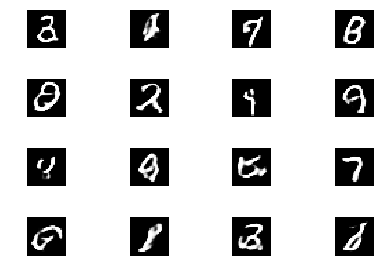

Epoch 711:
	D Network Loss: 0.686 Accuracy: 0.570
	Overall A Loss: 0.967 Accuracy: 0.055
Epoch 712:
	D Network Loss: 0.682 Accuracy: 0.557
	Overall A Loss: 0.759 Accuracy: 0.395
Epoch 713:
	D Network Loss: 0.686 Accuracy: 0.572
	Overall A Loss: 0.977 Accuracy: 0.086
Epoch 714:
	D Network Loss: 0.671 Accuracy: 0.578
	Overall A Loss: 0.785 Accuracy: 0.285
Epoch 715:
	D Network Loss: 0.703 Accuracy: 0.537
	Overall A Loss: 1.033 Accuracy: 0.035
Epoch 716:
	D Network Loss: 0.681 Accuracy: 0.570
	Overall A Loss: 0.741 Accuracy: 0.406
Epoch 717:
	D Network Loss: 0.699 Accuracy: 0.549
	Overall A Loss: 0.929 Accuracy: 0.129
Epoch 718:
	D Network Loss: 0.660 Accuracy: 0.625
	Overall A Loss: 0.831 Accuracy: 0.242
Epoch 719:
	D Network Loss: 0.698 Accuracy: 0.527
	Overall A Loss: 0.998 Accuracy: 0.039
Epoch 720:
	D Network Loss: 0.664 Accuracy: 0.600
	Overall A Loss: 0.744 Accuracy: 0.398


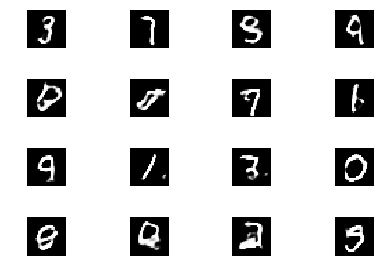

Epoch 721:
	D Network Loss: 0.692 Accuracy: 0.527
	Overall A Loss: 0.967 Accuracy: 0.086
Epoch 722:
	D Network Loss: 0.675 Accuracy: 0.564
	Overall A Loss: 0.795 Accuracy: 0.277
Epoch 723:
	D Network Loss: 0.684 Accuracy: 0.582
	Overall A Loss: 0.935 Accuracy: 0.105
Epoch 724:
	D Network Loss: 0.672 Accuracy: 0.570
	Overall A Loss: 0.819 Accuracy: 0.281
Epoch 725:
	D Network Loss: 0.707 Accuracy: 0.529
	Overall A Loss: 1.014 Accuracy: 0.035
Epoch 726:
	D Network Loss: 0.682 Accuracy: 0.576
	Overall A Loss: 0.734 Accuracy: 0.383
Epoch 727:
	D Network Loss: 0.691 Accuracy: 0.549
	Overall A Loss: 0.962 Accuracy: 0.070
Epoch 728:
	D Network Loss: 0.666 Accuracy: 0.588
	Overall A Loss: 0.809 Accuracy: 0.277
Epoch 729:
	D Network Loss: 0.677 Accuracy: 0.588
	Overall A Loss: 0.966 Accuracy: 0.062
Epoch 730:
	D Network Loss: 0.704 Accuracy: 0.490
	Overall A Loss: 0.864 Accuracy: 0.195


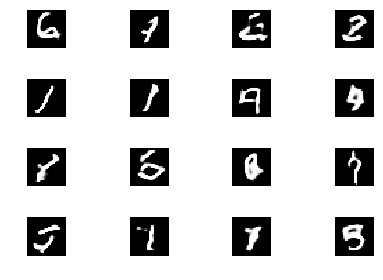

Epoch 731:
	D Network Loss: 0.680 Accuracy: 0.535
	Overall A Loss: 0.907 Accuracy: 0.141
Epoch 732:
	D Network Loss: 0.677 Accuracy: 0.564
	Overall A Loss: 0.787 Accuracy: 0.293
Epoch 733:
	D Network Loss: 0.698 Accuracy: 0.533
	Overall A Loss: 1.020 Accuracy: 0.020
Epoch 734:
	D Network Loss: 0.653 Accuracy: 0.662
	Overall A Loss: 0.733 Accuracy: 0.418
Epoch 735:
	D Network Loss: 0.689 Accuracy: 0.527
	Overall A Loss: 1.060 Accuracy: 0.031
Epoch 736:
	D Network Loss: 0.680 Accuracy: 0.562
	Overall A Loss: 0.729 Accuracy: 0.418
Epoch 737:
	D Network Loss: 0.694 Accuracy: 0.533
	Overall A Loss: 1.060 Accuracy: 0.031
Epoch 738:
	D Network Loss: 0.687 Accuracy: 0.557
	Overall A Loss: 0.761 Accuracy: 0.363
Epoch 739:
	D Network Loss: 0.709 Accuracy: 0.521
	Overall A Loss: 0.937 Accuracy: 0.082
Epoch 740:
	D Network Loss: 0.667 Accuracy: 0.586
	Overall A Loss: 0.776 Accuracy: 0.320


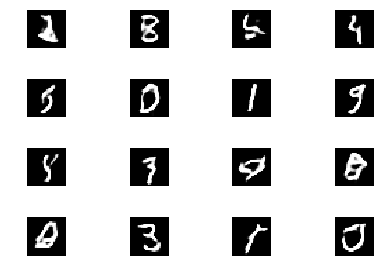

Epoch 741:
	D Network Loss: 0.690 Accuracy: 0.541
	Overall A Loss: 0.917 Accuracy: 0.125
Epoch 742:
	D Network Loss: 0.669 Accuracy: 0.586
	Overall A Loss: 0.778 Accuracy: 0.309
Epoch 743:
	D Network Loss: 0.684 Accuracy: 0.559
	Overall A Loss: 0.901 Accuracy: 0.152
Epoch 744:
	D Network Loss: 0.662 Accuracy: 0.611
	Overall A Loss: 0.857 Accuracy: 0.223
Epoch 745:
	D Network Loss: 0.672 Accuracy: 0.582
	Overall A Loss: 0.936 Accuracy: 0.102
Epoch 746:
	D Network Loss: 0.675 Accuracy: 0.541
	Overall A Loss: 0.797 Accuracy: 0.277
Epoch 747:
	D Network Loss: 0.685 Accuracy: 0.566
	Overall A Loss: 0.960 Accuracy: 0.090
Epoch 748:
	D Network Loss: 0.682 Accuracy: 0.557
	Overall A Loss: 0.800 Accuracy: 0.305
Epoch 749:
	D Network Loss: 0.697 Accuracy: 0.539
	Overall A Loss: 1.018 Accuracy: 0.055
Epoch 750:
	D Network Loss: 0.681 Accuracy: 0.570
	Overall A Loss: 0.829 Accuracy: 0.246


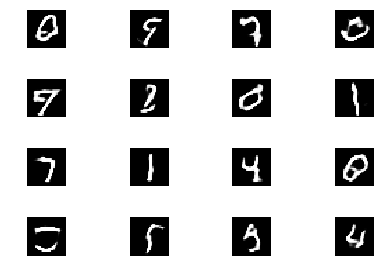

Epoch 751:
	D Network Loss: 0.673 Accuracy: 0.584
	Overall A Loss: 0.976 Accuracy: 0.082
Epoch 752:
	D Network Loss: 0.675 Accuracy: 0.559
	Overall A Loss: 0.859 Accuracy: 0.160
Epoch 753:
	D Network Loss: 0.697 Accuracy: 0.549
	Overall A Loss: 0.984 Accuracy: 0.059
Epoch 754:
	D Network Loss: 0.660 Accuracy: 0.604
	Overall A Loss: 0.799 Accuracy: 0.316
Epoch 755:
	D Network Loss: 0.695 Accuracy: 0.541
	Overall A Loss: 1.130 Accuracy: 0.012
Epoch 756:
	D Network Loss: 0.680 Accuracy: 0.541
	Overall A Loss: 0.650 Accuracy: 0.637
Epoch 757:
	D Network Loss: 0.720 Accuracy: 0.514
	Overall A Loss: 1.037 Accuracy: 0.012
Epoch 758:
	D Network Loss: 0.680 Accuracy: 0.576
	Overall A Loss: 0.747 Accuracy: 0.352
Epoch 759:
	D Network Loss: 0.695 Accuracy: 0.551
	Overall A Loss: 0.953 Accuracy: 0.066
Epoch 760:
	D Network Loss: 0.683 Accuracy: 0.559
	Overall A Loss: 0.767 Accuracy: 0.320


In [0]:
print("Beginning number generation")

deep_conv_gan = DCGAN()

img_rows = 28
img_cols = 28
channel = 1

x_train = input_data.read_data_sets(
    'mnist',
    one_hot=True
).train.images

x_train = x_train.reshape(
    -1,
    img_rows,
    img_cols,
    1
).astype(np.float32)

generator = deep_conv_gan.generator()
discriminator = deep_conv_gan.discriminator_model()
adversarial = deep_conv_gan.adversarial_model()

train(
    x_train,
    generator,
    discriminator,
    adversarial,
    img_rows, img_cols
)